<a href="https://colab.research.google.com/github/adamvoros/Delauney_triangulation_as_another_potential_flow_in_2d/blob/main/Deep_Impact_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# Google Drive csatlakoztatása
drive.mount('/content/drive')

# A fájl elérési útvonalának beállítása a Google Drive mappádban
file_path = '/content/drive/My Drive/PE MI szakmérnöki/Szakdolgozat/2010-01-22-deep-impact-8bit-1-of-7.dat'



def read_seti(Fs=8738113, time_sec=1, fid=None):
    if fid is None:
        raise ValueError("A fájl azonosítóját (fid) meg kell adni")

    N = Fs * time_sec * 2 # Kiszámítja a mintavételi frekvencia és az idő alapján, hány mintát kell olvasni
    coeffs = np.fromfile(fid, dtype=np.int8, count=N) # N darab 8-bites előjeles egész számot olvas be ('schar' a MATLAB-ban 'int8'-nak felel meg a NumPy-ban)
    data = coeffs[0::2] + 1j * coeffs[1::2] # Váltogatott mintákból összetett számokat képez

    return data, fid
#Alapértelmezett értékeket állít be Fs-nek és time_sec-nek, ha azokat nem adták meg.
#Kiszámolja, hány mintát kell olvasni (N), a megadott mintavételi frekvencia és időtartam alapján.
#N darab 8-bites előjeles egészet (int8) olvas be a fájlból a numpy.fromfile használatával.
#Összetett adatokat állít elő az egyes és páros indexű minták kombinálásával, hasonlóan a MATLAB kódhoz.
#Visszaadja a feldolgozott adatokat és a fájl azonosítóját (fid).

Mounted at /content/drive


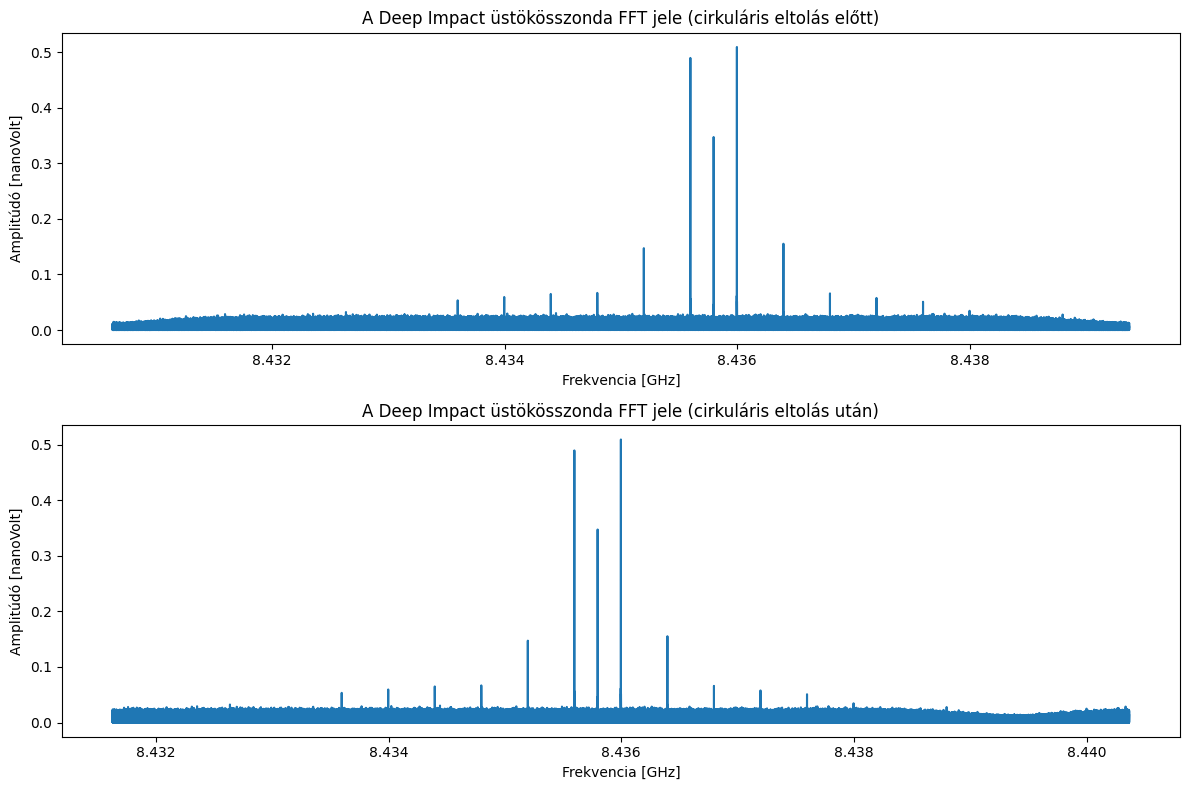

In [ ]:
##########################################################################################
# EZ CSAK TESZT 1 MÁSODPERCNYI MÉRÉSRE, HOGY TÉNYLEG ELTOLJA-E CIRKULÁRISAN A SPEKTRUMOT #
##########################################################################################

Fs = 8738113
N = 8738113
f = -997191
t = np.arange(N) / Fs
x_shift = np.exp(1j*2*np.pi*f*t)

# Fájl megnyitása olvasásra
with open(file_path, 'rb') as fid:
    nr = 0
    while nr < 1:
        data, fid = read_seti(Fs=8738113, time_sec=1, fid=fid)
        nr += 1

valosfreki = 8435000000

# FFT és spektrum-ábrázolás
Fs = 8738113
N = len(data)
f = -997191
valosfreki = 8435000000
f_axis = (np.arange(-Fs/2, Fs/2, Fs/N) + valosfreki) / 1e9
f_axis_ELTOLT = (np.arange(-Fs/2, Fs/2, Fs/N) + valosfreki - f) / 1e9

# Az eredeti adatsor FFT-je
X_fft = np.fft.fftshift(np.fft.fft(data))/N

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(f_axis, np.abs(X_fft))
plt.xlabel('Frekvencia [GHz]')
plt.ylabel('Amplitúdó [nanoVolt]')
plt.title('A Deep Impact üstökösszonda FFT jele (cirkuláris eltolás előtt)')

# Az eltolás utáni adatsor FFT-je
X_shift_fft = np.fft.fftshift(np.fft.fft(data*x_shift))/N

plt.subplot(212)
plt.plot(f_axis_ELTOLT, np.abs(X_shift_fft))
plt.xlabel('Frekvencia [GHz]')
plt.ylabel('Amplitúdó [nanoVolt]')
plt.title('A Deep Impact üstökösszonda FFT jele (cirkuláris eltolás után)')

plt.tight_layout()
plt.show()

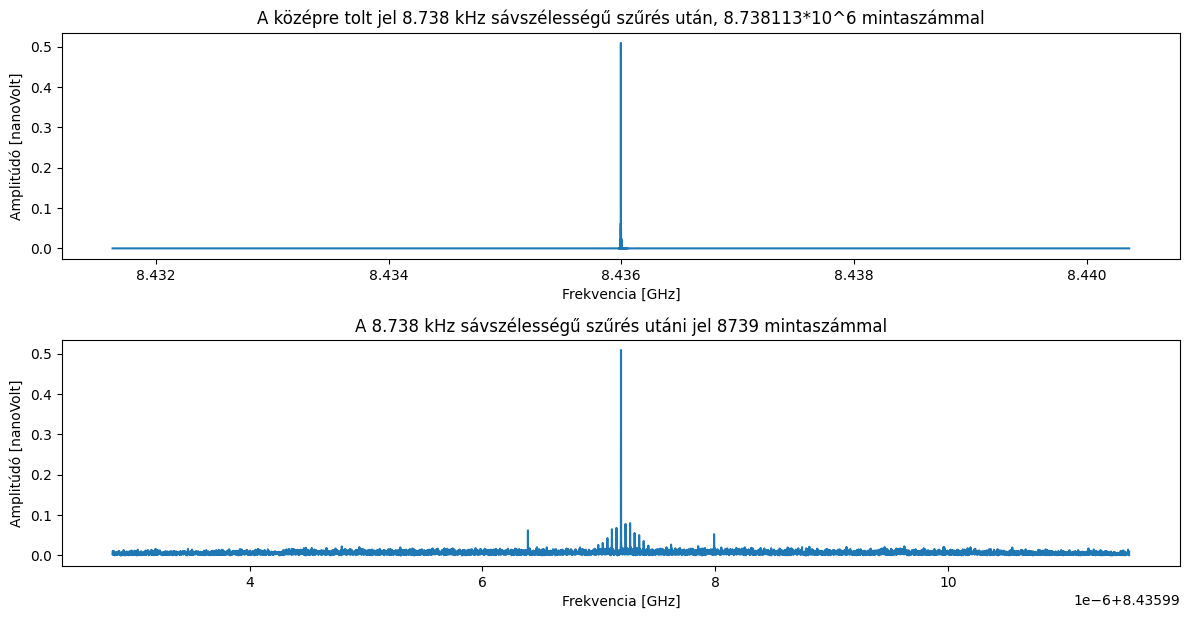

In [ ]:
######################################################################################
# EZ CSAK TESZT 1 MÁSODPERCNYI MÉRÉSRE, HOGY TÉNYLEG MEGSZŰRI-E AZ ELTOLT SPEKTRUMOT #
######################################################################################

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, freqz, lfilter

# Szűrő paraméterek
Fs = 8738113  # Mintavételi frekvencia
Fpass = 4369.0665  # Áteresztő sáv vége
Fstop = 8738.133  # Elvágási frekvencia
numtaps = 5623  # Szűrő hossza (fokszám)

# Aluláteresztő FIR szűrő létrehozása
lpf = firwin(numtaps, Fpass, fs=Fs, pass_zero='lowpass')

# Szűrő alkalmazása
filtered_signal = lfilter(lpf, 1.0, data * x_shift)

# FFT az eredeti eltolás utáni és a szűrt jelre
X_shift_fft_filtered = np.fft.fftshift(np.fft.fft(filtered_signal))/N

# Szűrt jel minden ezredik mintájának kiválasztása
downsampled_signal = filtered_signal[::1000]
N_downsampled = len(downsampled_signal)
Fs_downsampled = Fs / 1000

# FFT a szűrt és mintaelhagyott jelre
X_downsampled_fft = np.fft.fftshift(np.fft.fft(downsampled_signal))/N_downsampled

# Ábrázolás
plt.figure(998, figsize=(12, 12))

# Eltolás utáni jel szűrt verziója
plt.subplot(411)
f_axis_shift_filtered = (np.arange(-Fs/2, Fs/2, Fs/N) + valosfreki - f) / 1e9
plt.plot(f_axis_shift_filtered, np.abs(X_shift_fft_filtered))
plt.xlabel('Frekvencia [GHz]')
plt.ylabel('Amplitúdó [nanoVolt]')
plt.title('A középre tolt jel 8.738 kHz sávszélességű szűrés után, 8.738113*10^6 mintaszámmal')

# a szűrt és mintaelhagyott jel
plt.subplot(412)
f_axis_downsampled = (np.arange(-Fs_downsampled/2, Fs_downsampled/2, Fs_downsampled/N_downsampled) + valosfreki - f) / 1e9
plt.plot(f_axis_downsampled, np.abs(X_downsampled_fft))
plt.xlabel('Frekvencia [GHz]')
plt.ylabel('Amplitúdó [nanoVolt]')
plt.title('A 8.738 kHz sávszélességű szűrés utáni jel 8739 mintaszámmal')

plt.tight_layout()
plt.show()


In [ ]:
pip install numpy scipy

In [ ]:
##############################################################################
#                    KLT (WRITTEN BY DR. KORNYIK MIKLÓS)                     #
##############################################################################

import numpy as np
from itertools import combinations
# from numba import njit
import scipy as sp

def autocovmatrix(time_series:np.ndarray, biased:bool =True, center:bool =True)->np.ndarray:
    if center:
        time_series-=np.mean(time_series)
    # print(time_series.dtype)
    N = len(time_series)
    autocovariances = np.roll(np.correlate(time_series, time_series, mode='full'), shift=N)[:N]
    autocovariances =  autocovariances/N if biased else autocovariances/np.arange(N, 0, -1)
    A = sp.linalg.toeplitz(autocovariances).T
    return autocovariances, A
def autocorrmatrix(time_series:np.ndarray, biased:bool =True) -> np.ndarray:
    time_series-=np.mean(time_series)
    time_series/=max(np.std(time_series), 1E-7)
    N = len(time_series)
    autocorrs = np.roll(np.correlate(time_series, time_series, mode='full'), shift=N)[:N]
    autocorrs = autocorrs/N if biased else autocorrs/np.arange(N, 0, -1)
    A = sp.linalg.toeplitz(autocorrs).T
    return autocorrs, A

x = np.random.normal(size=5000) + 1j*np.random.normal(size=5000)

import time
start = time.time()
autocorrs, A = autocorrmatrix(x)
np.testing.assert_almost_equal(autocorrs, A[0,:])
end = time.time()
print(end-start)
start = time.time()
autocovs, A = autocovmatrix(x)
np.testing.assert_almost_equal(autocovs, A[0,:])
end = time.time()
print(end-start)


0.10247468948364258
0.10599780082702637


In [ ]:
del A

In [ ]:
#len(downsampled_signal)

In [ ]:
#KLT a szűrt és mintaelhagyott jelre:
#A = autocovmatrix(downsampled_signal)

In [ ]:
#print(A[1].shape)

In [ ]:
# Sajátértékek és sajátvektorok kiszámítása
#import scipy.linalg

#eigenvalues, eigenvectors = scipy.linalg.eigh(A[1])

In [ ]:
#eigenvalues.shape

In [ ]:
#eigenvectors.shape

In [ ]:
#del A
#del eigenvalues
#del eigenvectors

In [ ]:
##################################################################################
# MOST AZ ELTOLÁST, SZŰRÉST, MINTAELHAGYÁST TÖBB MÁSODPERCNYI MÉRÉSRE ALKALMAZVA #
##################################################################################
import scipy.linalg

Fs = 8738113
N = 8738113
f = -997191
t = np.arange(N) / Fs
x_shift = np.exp(1j*2*np.pi*f*t)

all_data_fft = []  # Ebben a listában gyűjtjük az adatokat
all_klt_values = []
all_klt_dominantvectors = []

with open(file_path, 'rb') as fid:
    nr = 0
    while nr < 3:
        data, fid = read_seti(Fs=8738113, time_sec=1, fid=fid)
        # Szűrő alkalmazása:
        filtered_sign = lfilter(lpf, 1.0, data * x_shift)
        # Szűrt jel minden ezredik mintájának kiválasztása:
        downsampled_sign = filtered_sign[::1000]
        N_downsamp = len(downsampled_sign)
        Fs_downsamp = Fs / 1000
        # FFT a szűrt és mintaelhagyott jelre:
        X_downsamp_fft = np.fft.fftshift(np.fft.fft(downsampled_sign))/N_downsamp

        all_data_fft.append(X_downsamp_fft)


        #KLT a szűrt és mintaelhagyott jelre:
        A = autocovmatrix(downsampled_sign)
        eigenvalues, eigenvectors = scipy.linalg.eigh(A[1])

        dominans_sajatvektor = eigenvectors[:, -1]


        all_klt_values.append(eigenvalues)
        all_klt_dominantvectors.append(dominans_sajatvektor)


        del A
        del eigenvalues
        del eigenvectors

        nr += 1

In [ ]:
all_data_fft


[array([ 3.19828430e-03-0.00048631j, -3.33776502e-03+0.00444355j,
        -7.60507601e-03-0.00854642j, ...,  1.30013427e-04+0.00549276j,
         5.01646632e-05+0.00036876j,  6.53819815e-03+0.00694429j]),
 array([-0.0083012 +0.00140133j, -0.00389089-0.00309781j,
         0.00586776+0.00502549j, ..., -0.0042631 -0.00224609j,
         0.00065438+0.00460971j,  0.00376383+0.00293103j]),
 array([-0.00625412+0.00429945j,  0.00661418-0.00380803j,
         0.00065194+0.00519105j, ..., -0.00672425+0.00210804j,
        -0.00423513+0.00418822j,  0.00153877+0.00640164j])]

In [ ]:
len(all_data_fft[0])

8739

In [ ]:
all_klt_values

[array([7.95755143e-03, 1.04219428e-02, 1.17391798e-02, ...,
        1.14538130e+02, 4.38865562e+02, 1.52237062e+03]),
 array([1.44456709e-02, 1.77026915e-02, 1.77768810e-02, ...,
        9.92167577e+01, 4.68661033e+02, 1.54104914e+03]),
 array([8.81195171e-03, 1.20093687e-02, 1.20886458e-02, ...,
        1.85056435e+02, 3.96798361e+02, 1.38210829e+03])]

In [ ]:
len(all_klt_values[0])

8739

In [ ]:
all_klt_dominantvectors

[array([-0.00798569-0.00000000e+00j, -0.00798809+5.43794322e-06j,
        -0.00798996+1.08949217e-05j, ..., -0.00752365-2.68965939e-03j,
        -0.00752372-2.68389095e-03j, -0.00752329-2.67796357e-03j]),
 array([-0.0078286 -0.00000000e+00j, -0.00783098+5.58790233e-06j,
        -0.00783284+1.11903260e-05j, ..., -0.00782733-2.93860067e-04j,
        -0.00782568-2.88194142e-04j, -0.0078235 -2.82523910e-04j]),
 array([0.00806006+0.00000000e+00j, 0.00806258-5.10180255e-06j,
        0.00806459-1.01966816e-05j, ..., 0.00604333+5.34002165e-03j,
        0.0060452 +5.33487681e-03j, 0.00604668+5.32938192e-03j])]

In [ ]:
len(all_klt_dominantvectors[0])

8739

In [ ]:
#FFT
import pandas as pd

series_list = [pd.Series(array) for array in all_data_fft]

df = pd.concat(series_list, axis=1).transpose()

In [ ]:
#KLT values

series_list2 = [pd.Series(array2) for array2 in all_klt_values]

df_klt_values = pd.concat(series_list2, axis=1).transpose()

In [ ]:
#KLT dominantvectors

series_list3 = [pd.Series(array3) for array3 in all_klt_dominantvectors]

df_klt_domvect = pd.concat(series_list3, axis=1).transpose()

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.003198-0.000486j,-0.003338+0.004444j,-0.007605-0.008546j,0.000620-0.001814j,-0.004446-0.001809j,-0.005373+0.003048j,-0.002298-0.003643j,-0.001126+0.003934j,0.008435-0.006037j,0.008723+0.000304j,...,0.004897+0.008351j,-0.002825+0.002866j,-0.002536-0.002191j,-0.002134-0.002213j,-0.005725+0.000388j,0.002046+0.006340j,-0.004667+0.000801j,0.000130+0.005493j,0.000050+0.000369j,0.006538+0.006944j
1,-0.008301+0.001401j,-0.003891-0.003098j,0.005868+0.005025j,-0.001459-0.001129j,-0.001568-0.004542j,-0.005828+0.006664j,-0.002471+0.002132j,0.000933-0.000353j,-0.001298-0.005607j,-0.002019+0.003220j,...,0.003714+0.000031j,0.004263+0.001598j,-0.001153-0.000013j,-0.000919+0.002070j,0.005792+0.002532j,0.001270+0.001988j,0.000974-0.000305j,-0.004263-0.002246j,0.000654+0.004610j,0.003764+0.002931j
2,-0.006254+0.004299j,0.006614-0.003808j,0.000652+0.005191j,-0.005869-0.003826j,0.004224-0.000352j,0.001841-0.001229j,0.001415+0.000917j,-0.002480-0.003390j,-0.005482+0.002263j,-0.005588-0.001264j,...,0.002393-0.003487j,-0.008743+0.000301j,0.003854+0.001453j,-0.002034-0.001229j,-0.001693+0.004087j,0.001523-0.008520j,0.000328-0.001324j,-0.006724+0.002108j,-0.004235+0.004188j,0.001539+0.006402j


In [ ]:
df_klt_values

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.007958,0.010422,0.011739,0.012733,0.014123,0.015362,0.015514,0.015624,0.015709,0.016971,...,23.879835,29.627388,31.971331,35.084036,35.310277,39.763098,62.831815,114.538130,438.865562,1522.370623
1,0.014446,0.017703,0.017777,0.017807,0.017919,0.018579,0.018927,0.018939,0.019375,0.019977,...,25.092835,28.123282,28.174388,36.894062,38.088557,38.291855,49.653791,99.216758,468.661033,1541.049140
2,0.008812,0.012009,0.012089,0.016960,0.017018,0.017943,0.018113,0.018238,0.018463,0.019302,...,24.623415,26.612680,27.494534,37.035285,38.744267,39.579750,84.117558,185.056435,396.798361,1382.108291


In [ ]:
df_klt_domvect

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,-0.007986-0.000000j,-0.007988+0.000005j,-0.007990+0.000011j,-0.007992+0.000016j,-0.007994+0.000022j,-0.007996+0.000027j,-0.007998+0.000033j,-0.008000+0.000038j,-0.008002+0.000044j,-0.008004+0.000049j,...,-0.007524-0.002730j,-0.007524-0.002725j,-0.007524-0.002719j,-0.007524-0.002713j,-0.007524-0.002707j,-0.007524-0.002701j,-0.007524-0.002695j,-0.007524-0.002690j,-0.007524-0.002684j,-0.007523-0.002678j
1,-0.007829-0.000000j,-0.007831+0.000006j,-0.007833+0.000011j,-0.007835+0.000017j,-0.007837+0.000022j,-0.007839+0.000028j,-0.007841+0.000034j,-0.007843+0.000039j,-0.007844+0.000045j,-0.007846+0.000050j,...,-0.007839-0.000334j,-0.007838-0.000328j,-0.007836-0.000322j,-0.007834-0.000317j,-0.007833-0.000311j,-0.007831-0.000305j,-0.007829-0.000300j,-0.007827-0.000294j,-0.007826-0.000288j,-0.007823-0.000283j
2,0.008060+0.000000j,0.008063-0.000005j,0.008065-0.000010j,0.008067-0.000015j,0.008069-0.000020j,0.008071-0.000026j,0.008073-0.000031j,0.008075-0.000036j,0.008077-0.000041j,0.008079-0.000046j,...,0.006030+0.005376j,0.006032+0.005371j,0.006034+0.005366j,0.006036+0.005361j,0.006038+0.005356j,0.006040+0.005350j,0.006042+0.005345j,0.006043+0.005340j,0.006045+0.005335j,0.006047+0.005329j


In [ ]:
df = df.abs()
df

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.003235,0.005558,0.011440,0.001917,0.004800,0.006177,0.004307,0.004092,0.010373,0.008728,...,0.009680,0.004024,0.003351,0.003074,0.005738,0.006662,0.004735,0.005494,0.000372,0.009538
1,0.008419,0.004973,0.007726,0.001845,0.004805,0.008853,0.003264,0.000997,0.005756,0.003801,...,0.003714,0.004552,0.001153,0.002265,0.006322,0.002359,0.001021,0.004819,0.004656,0.004770
2,0.007589,0.007632,0.005232,0.007006,0.004238,0.002213,0.001687,0.004200,0.005931,0.005729,...,0.004229,0.008748,0.004119,0.002377,0.004424,0.008655,0.001364,0.007047,0.005956,0.006584


In [ ]:
df_klt_domvect = df_klt_domvect.abs()
df_klt_domvect

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.007986,0.007988,0.007990,0.007992,0.007994,0.007996,0.007998,0.008000,0.008002,0.008004,...,0.008004,0.008002,0.008000,0.007998,0.007996,0.007994,0.007992,0.007990,0.007988,0.007986
1,0.007829,0.007831,0.007833,0.007835,0.007837,0.007839,0.007841,0.007843,0.007845,0.007846,...,0.007846,0.007845,0.007843,0.007841,0.007839,0.007837,0.007835,0.007833,0.007831,0.007829
2,0.008060,0.008063,0.008065,0.008067,0.008069,0.008071,0.008073,0.008075,0.008077,0.008079,...,0.008079,0.008077,0.008075,0.008073,0.008071,0.008069,0.008067,0.008065,0.008063,0.008060


(0.0, 0.03)

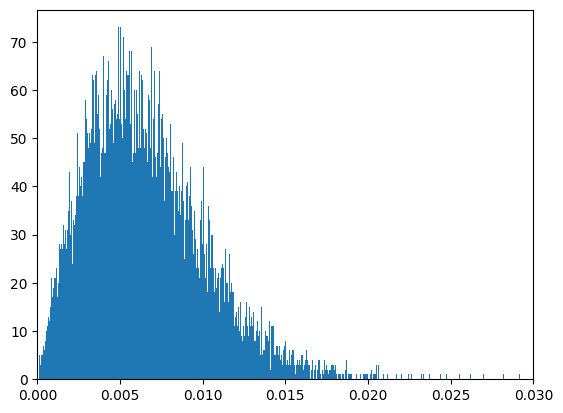

In [ ]:
##############################################
# EZ CSAK TESZT 1 MÁSODPERCNYI MÉRÉSRE (FFT) #
##############################################
plt.hist(np.abs(X_downsampled_fft), bins=8738)
plt.xlim([0, 0.03])

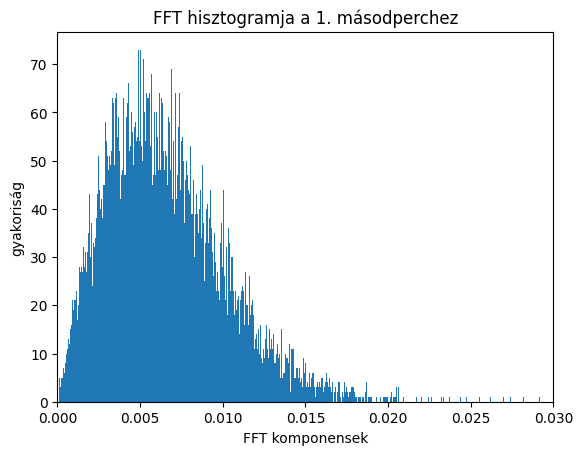

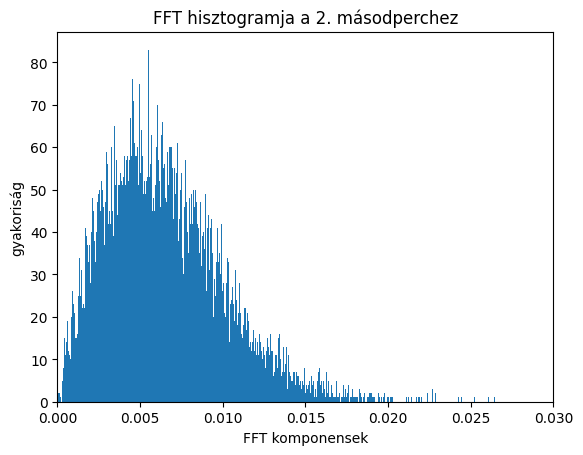

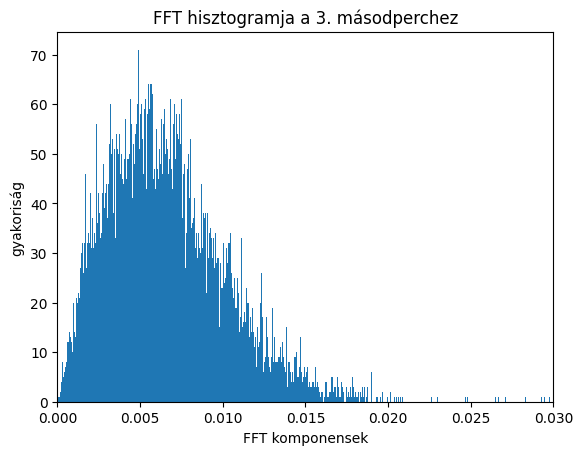

In [ ]:
##############################################
# TÖBB MÁSODPERCNYI MÉRÉSRE ALKALMAZVA (FFT) #
##############################################

# A hisztogramok megjelenítéséhez iteráljunk végig a DataFrame sorain
for index, row in df.iterrows():
    plt.figure()  # Új ábra létrehozása minden egyes sorhoz
    plt.xlim([0, 0.03])
    plt.hist(row, bins=8738 )  # A sor adatainak hisztogramja
    plt.title(f'FFT hisztogramja a {index+1}. másodperchez')
    plt.xlabel('FFT komponensek')
    plt.ylabel('gyakoriság')
    plt.show()

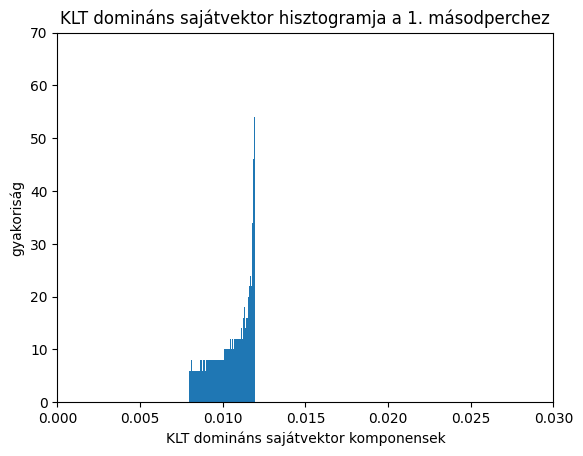

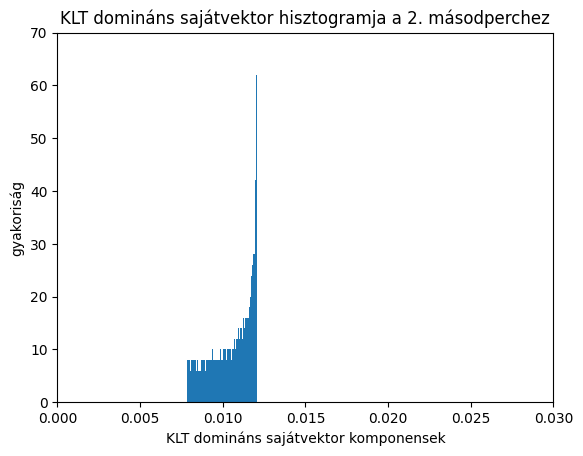

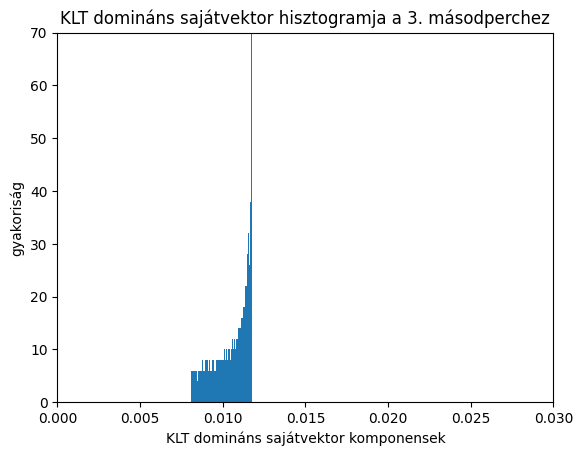

In [ ]:
######################################################
# TÖBB MÁSODPERCNYI MÉRÉSRE ALKALMAZVA (KLT DOMVECT) #
######################################################

# A hisztogramok megjelenítéséhez iteráljunk végig a DataFrame sorain
for index, row in df_klt_domvect.iterrows():
    plt.figure()  # Új ábra létrehozása minden egyes sorhoz
    plt.xlim([0, 0.03])
    plt.ylim([0, 70])
    plt.hist(row, bins=700 )  # A sor adatainak hisztogramja
    plt.title(f'KLT domináns sajátvektor hisztogramja a {index+1}. másodperchez')
    plt.xlabel('KLT domináns sajátvektor komponensek')
    plt.ylabel('gyakoriság')
    plt.show()

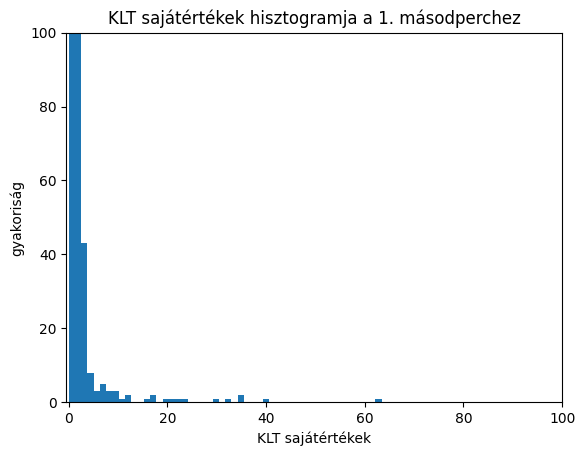

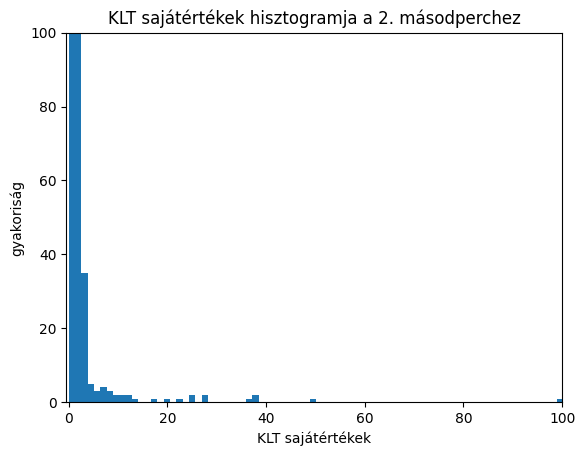

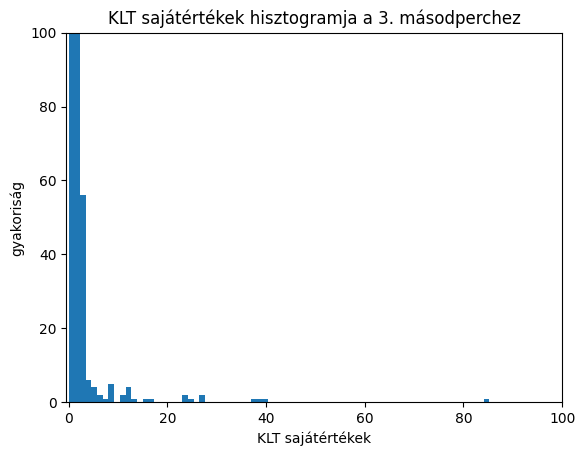

In [ ]:
###########################################################
# TÖBB MÁSODPERCNYI MÉRÉSRE ALKALMAZVA (KLT SAJÁTÉRTÉKEK) #
###########################################################


# A hisztogramok megjelenítéséhez iteráljunk végig a DataFrame sorain
for index, row in df_klt_values.iterrows():
    plt.figure()  # Új ábra létrehozása minden egyes sorhoz
    plt.xlim([-0.5, 100])
    plt.ylim([0, 100])
    plt.hist(row, bins=1200 )  # A sor adatainak hisztogramja
    plt.title(f'KLT sajátértékek hisztogramja a {index+1}. másodperchez')
    plt.xlabel('KLT sajátértékek')
    plt.ylabel('gyakoriság')
    plt.show()

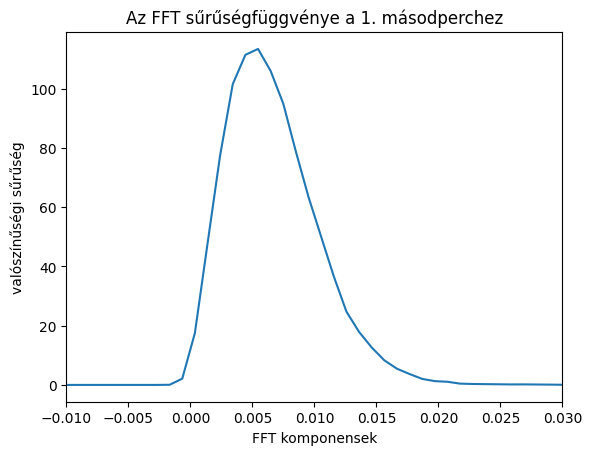

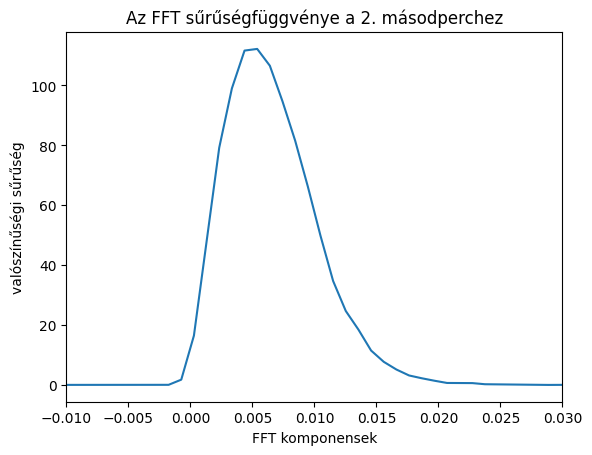

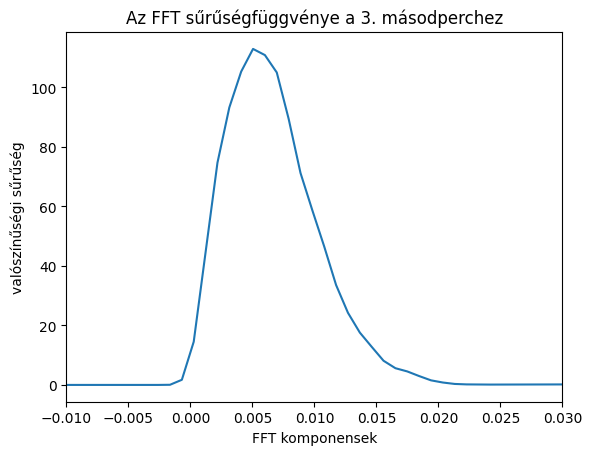

In [ ]:
####################################
# FFT KOMPONENSEK SŰRŰSÉGFÜGGVÉNYE #
####################################

import matplotlib.pyplot as plt

for index, row in df.iterrows():
    plt.figure()
    row.plot.density(bw_method=0.1)  # Pandas density plot az adott sorra
    plt.xlim([-0.01, 0.03])
    plt.title(f'Az FFT sűrűségfüggvénye a {index+1}. másodperchez')
    plt.xlabel('FFT komponensek')
    plt.ylabel('valószínűségi sűrűség')
    plt.show()

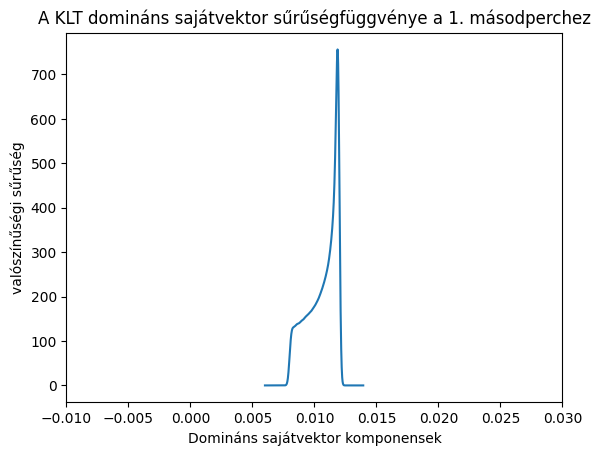

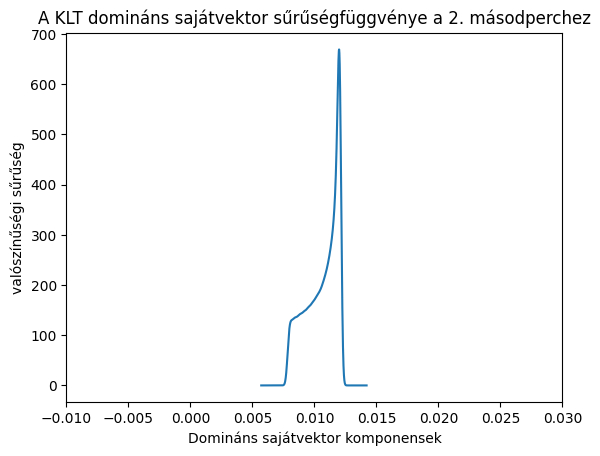

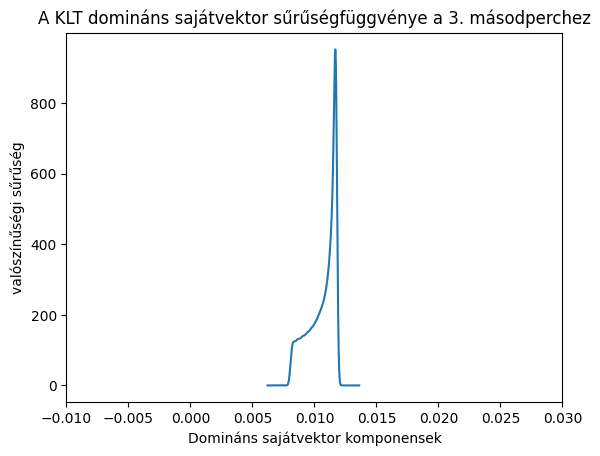

In [ ]:
#########################################################
# KLT DOMINÁNS SAJÁTVEKTOR KOMPONENSEK SŰRŰSÉGFÜGGVÉNYE #
#########################################################

import matplotlib.pyplot as plt

for index, row in df_klt_domvect.iterrows():
    plt.figure()
    row.plot.density(bw_method=0.1)  # Pandas density plot az adott sorra
    plt.xlim([-0.01, 0.03])
    plt.title(f'A KLT domináns sajátvektor sűrűségfüggvénye a {index+1}. másodperchez')
    plt.xlabel('Domináns sajátvektor komponensek')
    plt.ylabel('valószínűségi sűrűség')
    plt.show()

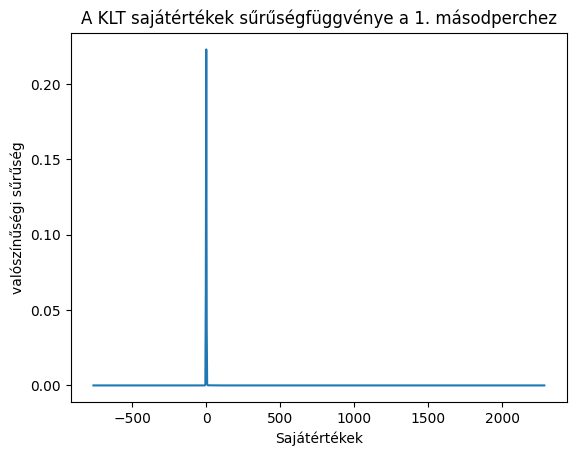

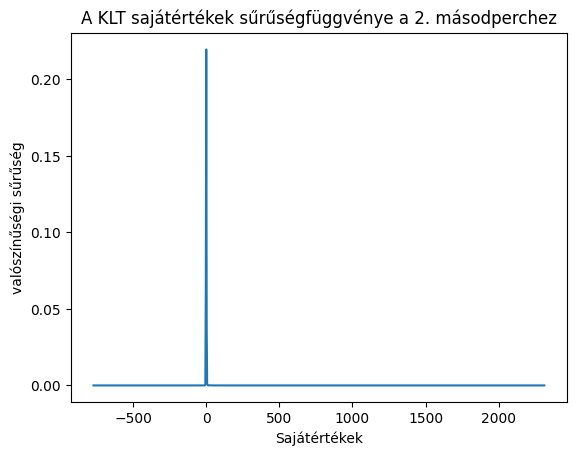

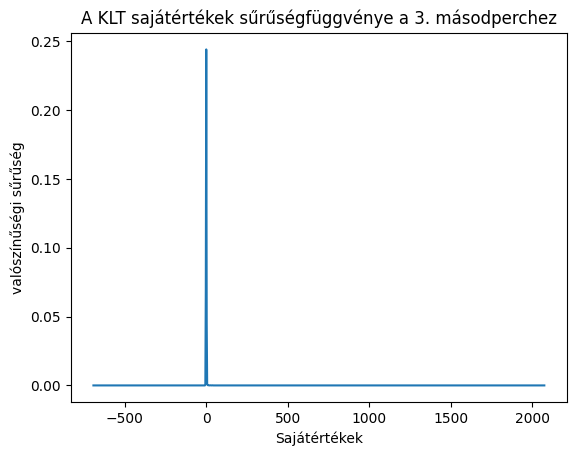

In [ ]:
#####################################
# KLT SAJÁTÉRTÉKEK SŰRŰSÉGFÜGGVÉNYE #
#####################################

import matplotlib.pyplot as plt

for index, row in df_klt_values.iterrows():
    plt.figure()
    row.plot.density(bw_method=0.1)  # Pandas density plot az adott sorra

    plt.title(f'A KLT sajátértékek sűrűségfüggvénye a {index+1}. másodperchez')
    plt.xlabel('Sajátértékek')
    plt.ylabel('valószínűségi sűrűség')
    plt.show()

In [ ]:
# FFT mértékek

for index, row in df.iterrows():
    sk = row.skew()
    median = row.median()
    mean = row.mean()
    mode = row.mode()[0] if not row.mode().empty else 'N/A'  # A mode() üres DataFrame-t adhat vissza, ha nincs módus
    print(f'{index+1} másodperc értékei: Ferdeség: {sk}, Medián: {median}, Átlag: {mean}, Módusz: {mode}')

1 másodperc értékei: Ferdeség: 47.73033247616009, Medián: 0.00612335246044859, Átlag: 0.00674856144947034, Módusz: 9.846457077130949e-05
2 másodperc értékei: Ferdeség: 48.57746918085249, Medián: 0.006085373156300953, Átlag: 0.006664921633486652, Módusz: 2.0656987419162775e-05
3 másodperc értékei: Ferdeség: 41.42297117308297, Medián: 0.006166308205746329, Átlag: 0.006780095143133817, Módusz: 2.120473632944917e-05


In [ ]:
# KLT domináns sajátvektor mértékek

for index, row in df_klt_domvect.iterrows():
    sk = row.skew()
    median = row.median()
    mean = row.mean()
    mode = row.mode()[0] if not row.mode().empty else 'N/A'  # A mode() üres DataFrame-t adhat vissza, ha nincs módus
    print(f'{index+1} másodperc értékei: Ferdeség: {sk}, Medián: {median}, Átlag: {mean}, Módusz: {mode}')

1 másodperc értékei: Ferdeség: -0.6414858075951676, Medián: 0.010962951935448112, Átlag: 0.010631458301124852, Módusz: 0.007994007737421779
2 másodperc értékei: Ferdeség: -0.5909718181438272, Medián: 0.010957704485371558, Átlag: 0.01062015275676718, Módusz: 0.008025680325128473
3 másodperc értékei: Ferdeség: -0.7995339749056295, Medián: 0.011026809595913768, Átlag: 0.010641589799112297, Módusz: 0.008082981728018952


In [ ]:
# KLT sajátértékek mértékei

for index, row in df_klt_values.iterrows():
    sk = row.skew()
    median = row.median()
    mean = row.mean()
    mode = row.mode()[0] if not row.mode().empty else 'N/A'  # A mode() üres DataFrame-t adhat vissza, ha nincs módus
    print(f'{index+1} másodperc értékei: Ferdeség: {sk}, Medián: {median}, Átlag: {mean}, Módusz: {mode}')

1 másodperc értékei: Ferdeség: 83.560981821583, Medián: 0.36693763555656356, Átlag: 0.7954382265483267, Módusz: 0.007957551430561796
2 másodperc értékei: Ferdeség: 83.09049482269789, Medián: 0.3606337205860741, Átlag: 0.7840190833258698, Módusz: 0.014445670936043325
3 másodperc értékei: Ferdeség: 82.08481810653926, Medián: 0.36551124467270807, Átlag: 0.7792985350609081, Módusz: 0.008811951712915565






# **Measures of variability**

In [ ]:
# FFT
# Ezek az azonos frekvenciakomponensekhez tartozó, különböző mérési másodpercek közötti variabilitások mértékei (szűrés és mintaelhagyás után):
df.describe().loc['max'] - df.describe().loc['min']

0       0.005184
1       0.002659
2       0.006208
3       0.005161
4       0.000566
          ...   
8734    0.006296
8735    0.003714
8736    0.002228
8737    0.005584
8738    0.004767
Length: 8739, dtype: float64

In [ ]:
# KLT domináns sajátvektor
# Ezek az azonos komponensekhez tartozó, különböző mérési másodpercek közötti variabilitások mértékei (szűrés és mintaelhagyás után):
df_klt_domvect.describe().loc['max'] - df_klt_domvect.describe().loc['min']

0       0.000231
1       0.000232
2       0.000232
3       0.000232
4       0.000232
          ...   
8734    0.000232
8735    0.000232
8736    0.000232
8737    0.000232
8738    0.000231
Length: 8739, dtype: float64

In [ ]:
# KLT sajátértékek
# Ezek az azonos komponensekhez tartozó, különböző mérési másodpercek közötti variabilitások mértékei (szűrés és mintaelhagyás után):
df_klt_values.describe().loc['max'] - df_klt_values.describe().loc['min']

0         0.006488
1         0.007281
2         0.006038
3         0.005074
4         0.003797
           ...    
8734      1.471243
8735     34.463768
8736     85.839677
8737     71.862672
8738    158.940849
Length: 8739, dtype: float64

In [ ]:
df.var()

0       7.752996e-06
1       1.952179e-06
2       9.760185e-06
3       8.756368e-06
4       1.060608e-07
            ...     
8734    1.035359e-05
8735    4.211496e-06
8736    1.305457e-06
8737    8.537380e-06
8738    5.790430e-06
Length: 8739, dtype: float64

In [ ]:
df_klt_domvect.var()

0       1.396443e-08
1       1.397909e-08
2       1.399350e-08
3       1.400395e-08
4       1.401066e-08
            ...     
8734    1.401066e-08
8735    1.400395e-08
8736    1.399350e-08
8737    1.397909e-08
8738    1.396443e-08
Length: 8739, dtype: float64

In [ ]:
df_klt_values.var()

0          0.000012
1          0.000015
2          0.000011
3          0.000007
4          0.000004
           ...     
8734       0.642808
8735     302.415747
8736    2096.004334
8737    1303.610529
8738    7547.433680
Length: 8739, dtype: float64

In [ ]:
# FFT
# Ezek minden oszlop (az azonos frekvenciakomponensekhez tartozó, különböző mérési másodpercek közötti) változékonysági együtthatói.
# A standard eltérés és az átlag hányadosa, százalékban kifejezve, az adatok relatív szóródását jellemzi.
df.std()/df.mean()*100

0       43.409079
1       23.077688
2       38.415009
3       82.448612
4        7.057822
          ...    
8734    54.610465
8735    86.466364
8736    19.744982
8737    79.800864
8738    34.553324
Length: 8739, dtype: float64

In [ ]:
# KLT domináns sajátvektor
# Ezek minden oszlop (az azonos komponensekhez tartozó, különböző mérési másodpercek közötti) változékonysági együtthatói.
# A standard eltérés és az átlag hányadosa, százalékban kifejezve, az adatok relatív szóródását jellemzi.
df_klt_domvect.std()/df_klt_domvect.mean()*100

0       1.484914
1       1.485238
2       1.485646
3       1.485811
4       1.485795
          ...   
8734    1.485795
8735    1.485811
8736    1.485646
8737    1.485238
8738    1.484914
Length: 8739, dtype: float64

In [ ]:
# KLT sajátértékek
# Ezek minden oszlop (az azonos komponensekhez tartozó, különböző mérési másodpercek közötti) változékonysági együtthatói.
# A standard eltérés és az átlag hányadosa, százalékban kifejezve, az adatok relatív szóródását jellemzi.
df_klt_values.std()/df_klt_values.mean()*100

0       33.880194
1       28.617662
2       24.440695
3       17.165714
4       12.130149
          ...    
8734     2.044685
8735    26.535847
8736    34.438947
8737     8.304421
8738     5.862698
Length: 8739, dtype: float64

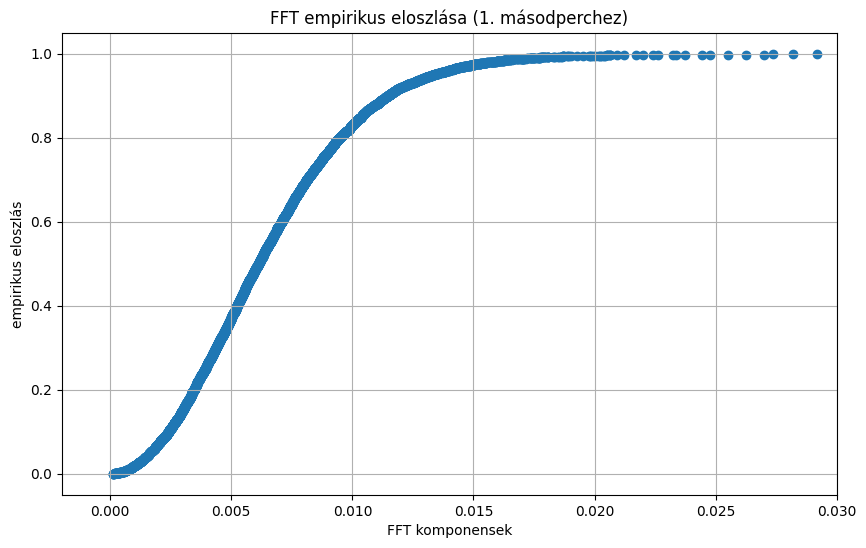

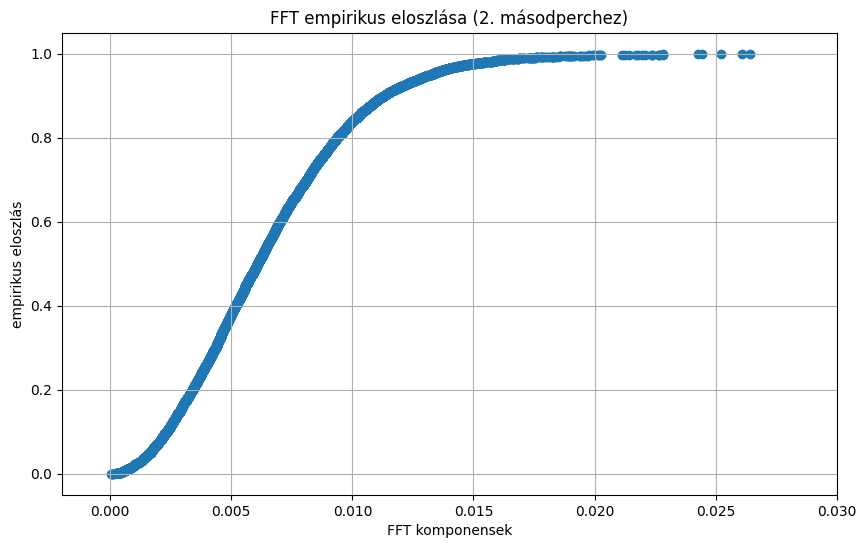

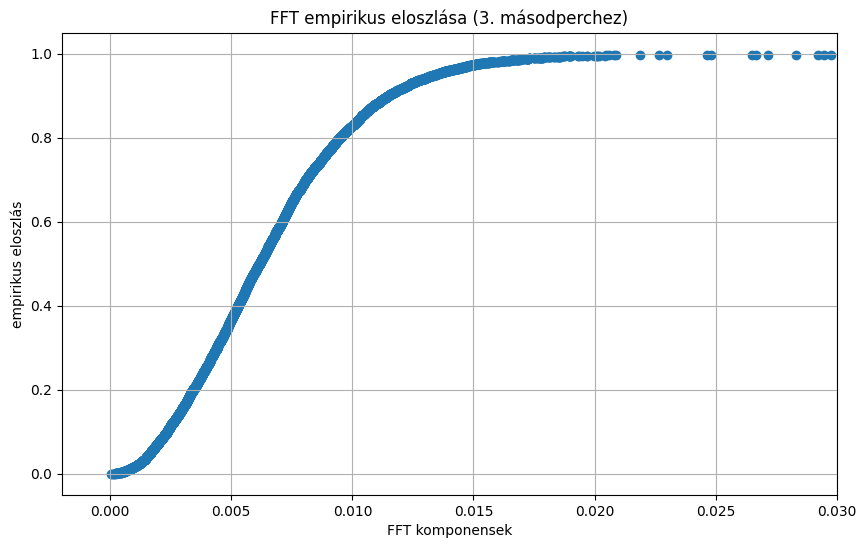

In [ ]:
# FFT

for index, row in df.iterrows():
    # Sor adatok rendezése
    row_sorted = row.sort_values()
    # Az empirikus eloszlás számítása
    p = np.arange(0, len(row)) / len(row)
    # Ábra készítése
    plt.figure(figsize=(10, 6)) # Ábra méretének beállítása
    plt.scatter(row_sorted, p)
    plt.xlim([-0.002, 0.03])
    plt.title(f'FFT empirikus eloszlása ({index+1}. másodperchez)')
    plt.xlabel('FFT komponensek')
    plt.ylabel('empirikus eloszlás')
    plt.grid(True)
    plt.show()

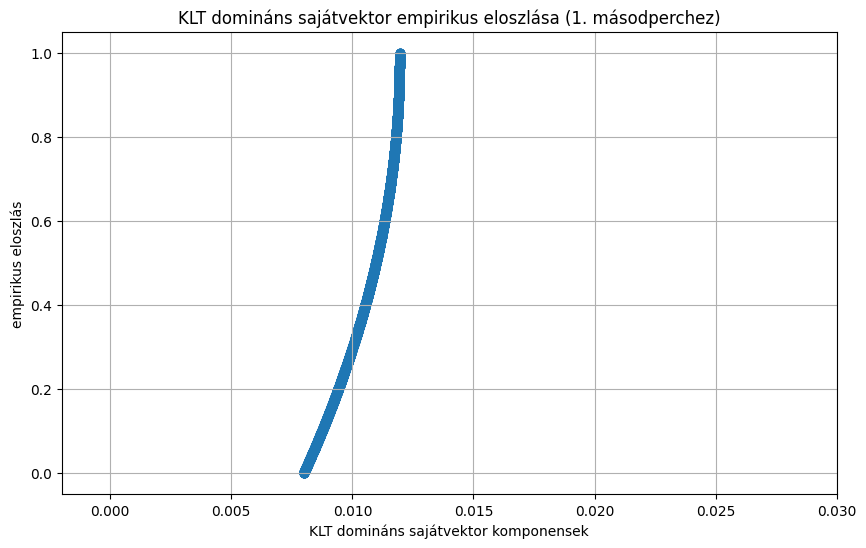

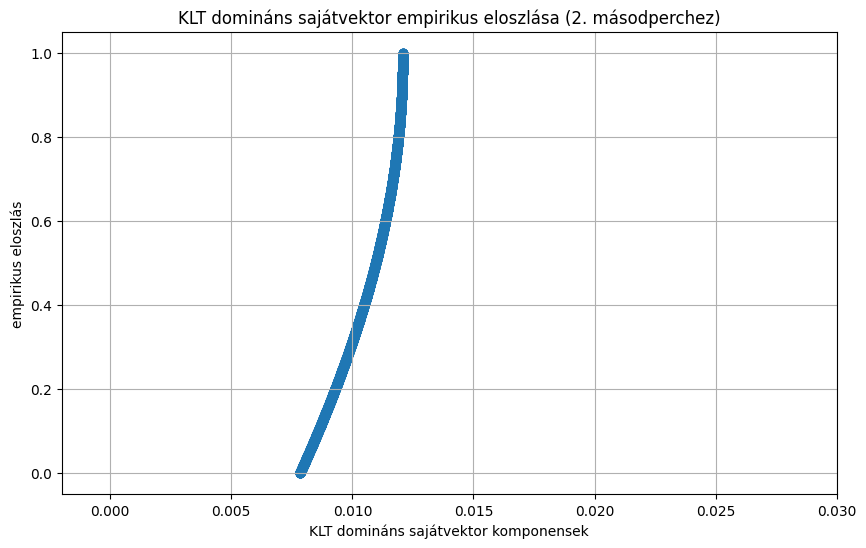

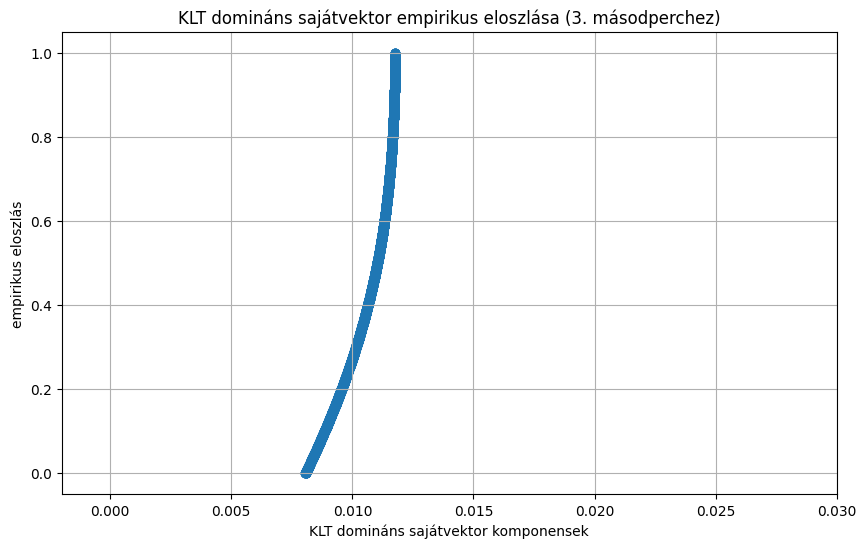

In [ ]:
# KLT domináns sajátvektor

for index, row in df_klt_domvect.iterrows():
    # Sor adatok rendezése
    row_sorted = row.sort_values()
    # Az empirikus eloszlás számítása
    p = np.arange(0, len(row)) / len(row)
    # Ábra készítése
    plt.figure(figsize=(10, 6)) # Ábra méretének beállítása
    plt.scatter(row_sorted, p)
    plt.xlim([-0.002, 0.03])
    plt.title(f'KLT domináns sajátvektor empirikus eloszlása ({index+1}. másodperchez)')
    plt.xlabel('KLT domináns sajátvektor komponensek')
    plt.ylabel('empirikus eloszlás')
    plt.grid(True)
    plt.show()

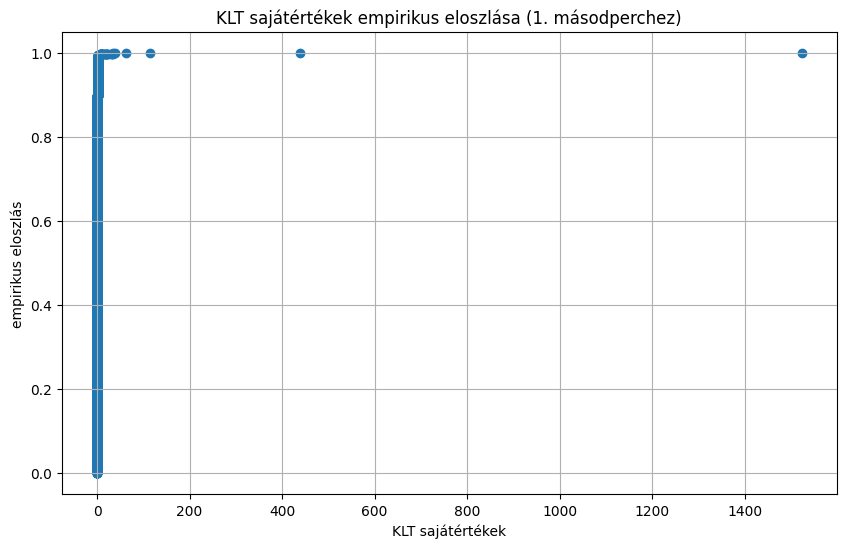

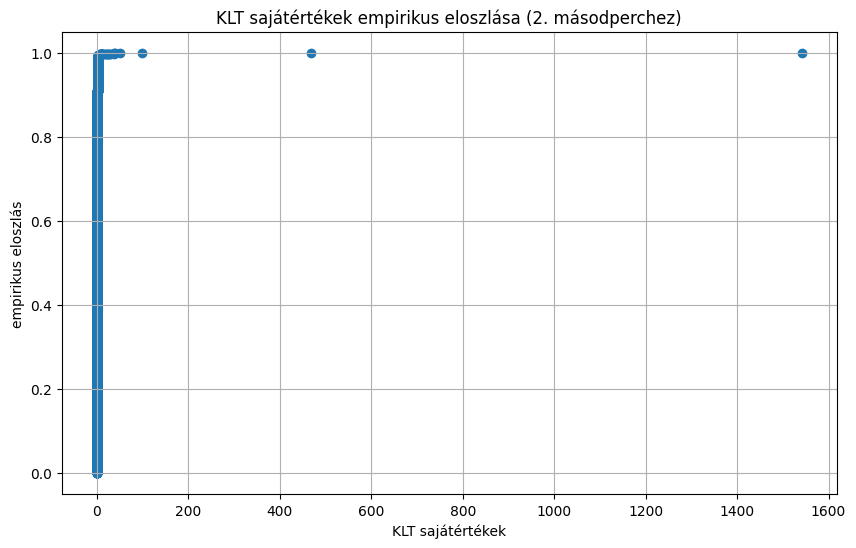

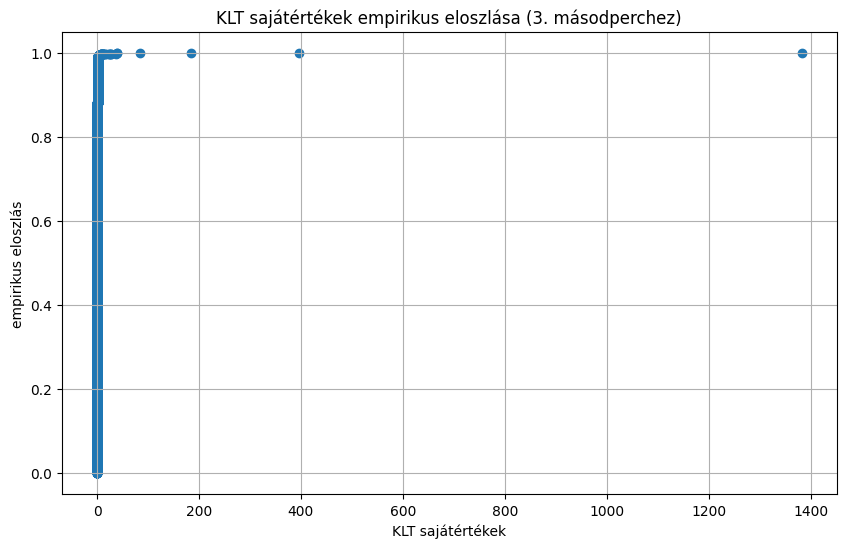

In [ ]:
# KLT sajátértékek

for index, row in df_klt_values.iterrows():
    # Sor adatok rendezése
    row_sorted = row.sort_values()
    # Az empirikus eloszlás számítása
    p = np.arange(0, len(row)) / len(row)
    # Ábra készítése
    plt.figure(figsize=(10, 6)) # Ábra méretének beállítása
    plt.scatter(row_sorted, p)
    plt.title(f'KLT sajátértékek empirikus eloszlása ({index+1}. másodperchez)')
    plt.xlabel('KLT sajátértékek')
    plt.ylabel('empirikus eloszlás')
    plt.grid(True)
    plt.show()

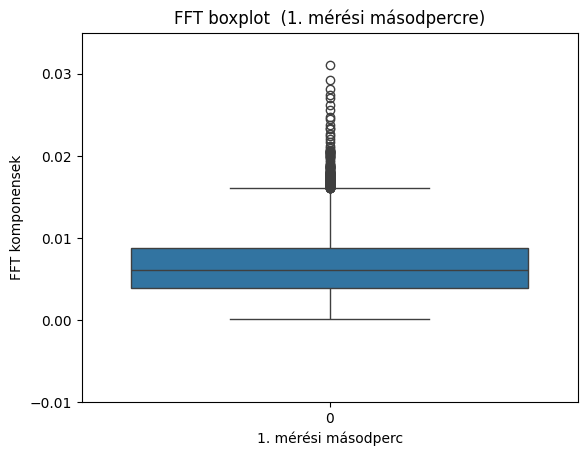

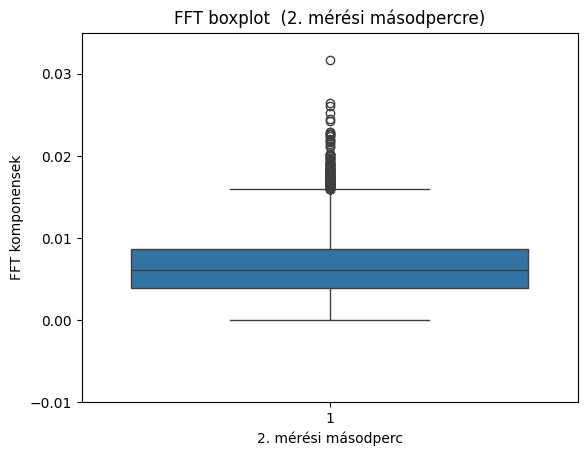

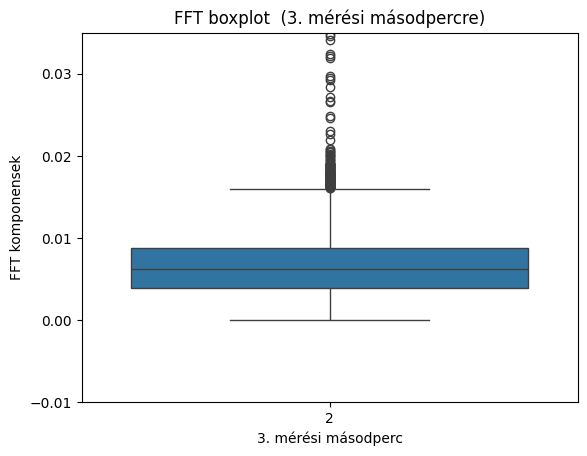

In [ ]:
# FFT

import seaborn as sns
import matplotlib.pyplot as plt

# A DataFrame transzponálása, hogy a sorok oszloppá váljanak (seaborn boxplotokat soronként készíteni egy DataFrame-ből egy kicsit körülményes)
df_transposed = df.T

# Iterálás minden egyes új oszlopon (eredetileg sorok)
for column in df_transposed.columns:
    plt.figure()  # Új ábra létrehozása minden egyes boxplot számára
    plt.ylim([-0.01, 0.035])
    plt.title(f'FFT boxplot  ({column+1}. mérési másodpercre)')
    plt.ylabel('FFT komponensek')
    plt.xlabel(f'{column+1}. mérési másodperc')
    sns.boxplot(data=df_transposed[[column]])
    plt.show()

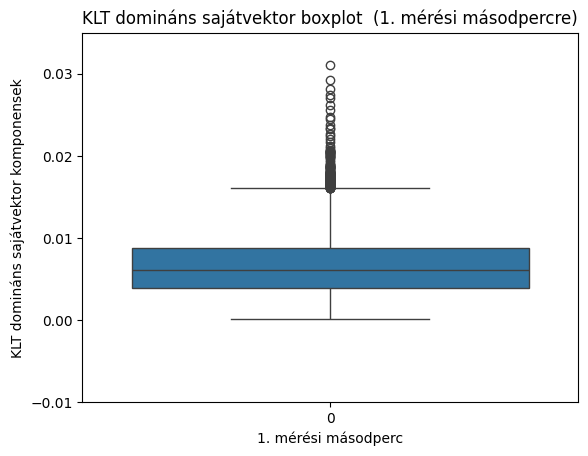

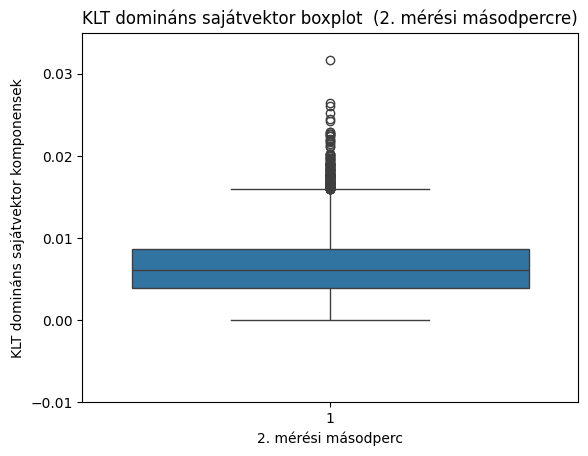

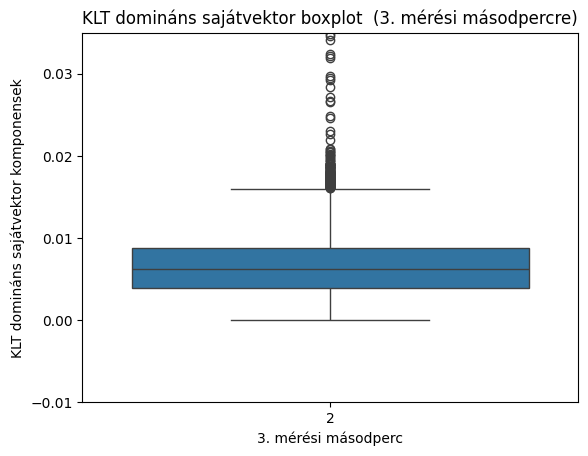

In [ ]:
# KLT domináns sajátvektor

# A DataFrame transzponálása, hogy a sorok oszloppá váljanak (seaborn boxplotokat soronként készíteni egy DataFrame-ből egy kicsit körülményes)
df_klt_domvect_transposed = df_klt_domvect.T

# Iterálás minden egyes új oszlopon (eredetileg sorok)
for column in df_klt_domvect_transposed.columns:
    plt.figure()  # Új ábra létrehozása minden egyes boxplot számára
    plt.ylim([-0.01, 0.035])
    plt.title(f'KLT domináns sajátvektor boxplot  ({column+1}. mérési másodpercre)')
    plt.ylabel('KLT domináns sajátvektor komponensek')
    plt.xlabel(f'{column+1}. mérési másodperc')
    sns.boxplot(data=df_transposed[[column]])
    plt.show()

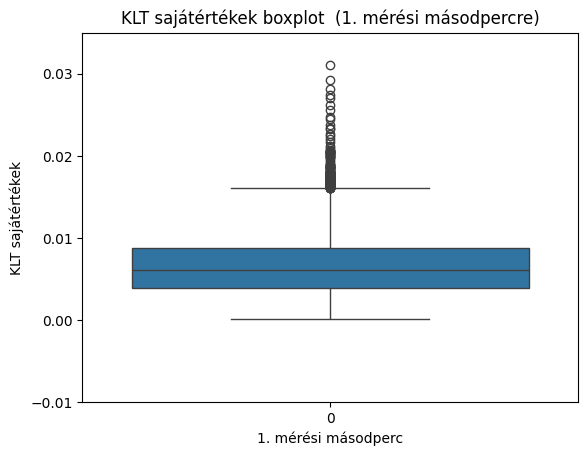

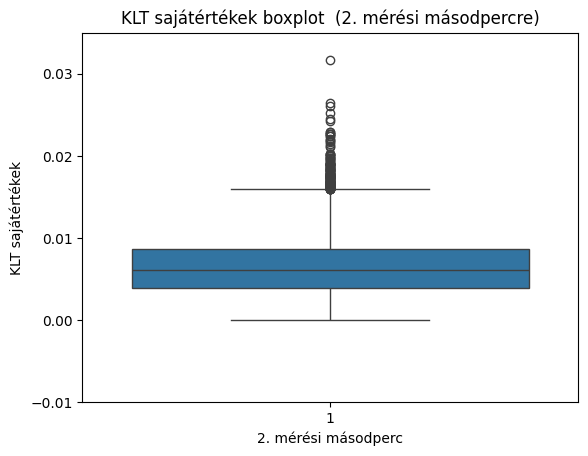

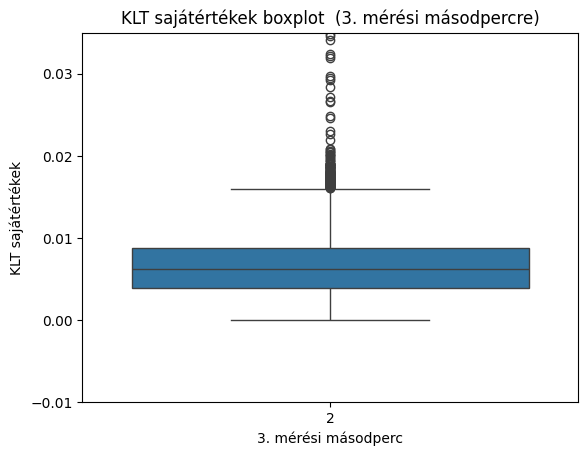

In [ ]:
# KLT sajátértékek

# A DataFrame transzponálása, hogy a sorok oszloppá váljanak (seaborn boxplotokat soronként készíteni egy DataFrame-ből egy kicsit körülményes)
df_klt_values_transposed = df_klt_values.T

# Iterálás minden egyes új oszlopon (eredetileg sorok)
for column in df_klt_values_transposed.columns:
    plt.figure()  # Új ábra létrehozása minden egyes boxplot számára
    plt.ylim([-0.01, 0.035])
    plt.title(f'KLT sajátértékek boxplot  ({column+1}. mérési másodpercre)')
    plt.ylabel('KLT sajátértékek')
    plt.xlabel(f'{column+1}. mérési másodperc')
    sns.boxplot(data=df_transposed[[column]])
    plt.show()

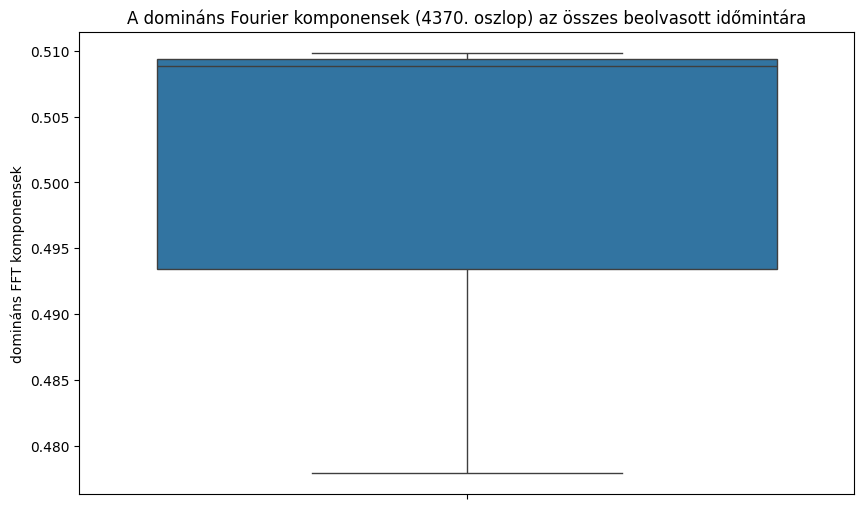

In [ ]:
# FFT

# Minden oszlop átlagának kiszámítása:
column_means = df.mean()
# A legnagyobb átlaggal rendelkező oszlop nevének meghatározása:
max_mean_column = column_means.idxmax()


# A legnagyobb átlaggal rendelkező oszlop ábrázolása boxplot segítségével
plt.figure(figsize=(10, 6))  # Beállítjuk az ábra méretét
sns.boxplot(data=df[max_mean_column])  # Az idxmax() a legnagyobb átlagú oszlop nevét adja vissza
plt.title(f'A domináns Fourier komponensek ({max_mean_column}. oszlop) az összes beolvasott időmintára')
plt.ylabel('domináns FFT komponensek')
plt.show()

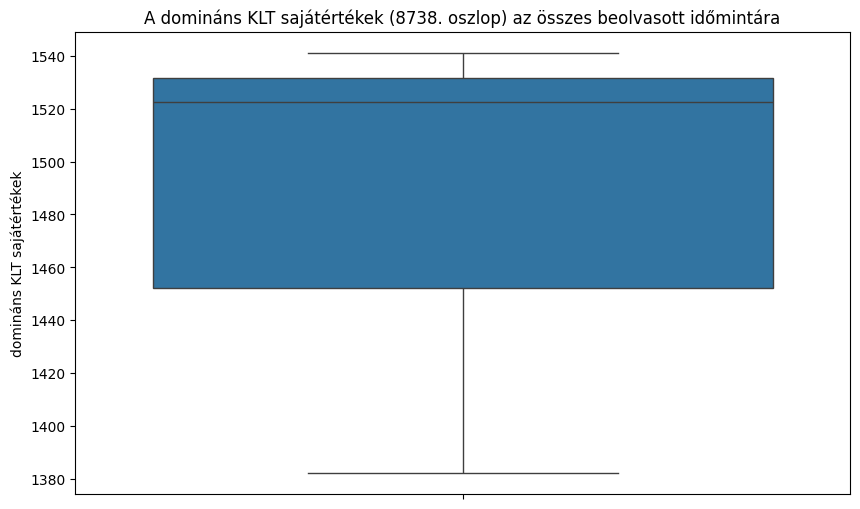

In [ ]:
# KLT sajátértékek

# Minden oszlop átlagának kiszámítása:
column_means_values = df_klt_values.mean()
# A legnagyobb átlaggal rendelkező oszlop nevének meghatározása:
max_mean_column_values = column_means_values.idxmax()


# A legnagyobb átlaggal rendelkező oszlop ábrázolása boxplot segítségével
plt.figure(figsize=(10, 6))  # Beállítjuk az ábra méretét
sns.boxplot(data=df_klt_values[max_mean_column_values])  # Az idxmax() a legnagyobb átlagú oszlop nevét adja vissza
plt.title(f'A domináns KLT sajátértékek ({max_mean_column_values}. oszlop) az összes beolvasott időmintára')
plt.ylabel('domináns KLT sajátértékek')
plt.show()

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.003235,0.005558,0.011440,0.001917,0.004800,0.006177,0.004307,0.004092,0.010373,0.008728,...,0.009680,0.004024,0.003351,0.003074,0.005738,0.006662,0.004735,0.005494,0.000372,0.009538
1,0.008419,0.004973,0.007726,0.001845,0.004805,0.008853,0.003264,0.000997,0.005756,0.003801,...,0.003714,0.004552,0.001153,0.002265,0.006322,0.002359,0.001021,0.004819,0.004656,0.004770
2,0.007589,0.007632,0.005232,0.007006,0.004238,0.002213,0.001687,0.004200,0.005931,0.005729,...,0.004229,0.008748,0.004119,0.002377,0.004424,0.008655,0.001364,0.007047,0.005956,0.006584


In [ ]:
# FFT

# A DataFrame transzponálása, hogy a sorok oszloppá váljanak
df_transposed = df.T.reset_index(drop=True)

# Kvartilisek és IQR számítása az újonnan transzponált DataFrame-re
Q1 = df_transposed.quantile(0.25)
Q3 = df_transposed.quantile(0.75)
IQR = Q3 - Q1

# IQR kiíratása
print(IQR)
print('----------------------------------------------------------------')

# Resetelem az indexet a logikai feltételek alkalmazása előtt
df_transposed = df_transposed.reset_index(drop=True)

# Kiugró értékek szűrése a transzponált DataFrame-ben, sorok szerint
# KISZEDTEM A NEGÁCIÓ ~ JELÉT MERT A SETI-BEN ÉPP A KIUGRÓ ADATOKAT KERESSÜK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_transposed_clean = df_transposed[((df_transposed < (Q1 - 1.5 * IQR)) | (df_transposed > (Q3 + 1.5 * IQR))).any(axis=1)]

# A kiugró adatok számának kiíratása (opcionálisan visszatranszponálható az eredeti formátumra)
print('Kiugró adatok:', df_transposed_clean.shape)

# Vissza akarom alakítani a DataFrame-et az eredeti sor/oszlop struktúrára
df_clean = df_transposed_clean.T
print('Kiugró adatok:', df_clean.shape)


0    0.004840
1    0.004819
2    0.004825
dtype: float64
----------------------------------------------------------------
Kiugró adatok: (398, 3)
Kiugró adatok: (3, 398)


In [ ]:
# KLT domináns sajátvektor

# A DataFrame transzponálása, hogy a sorok oszloppá váljanak
df_klt_domvect_transposed = df_klt_domvect.T.reset_index(drop=True)

# Kvartilisek és IQR számítása az újonnan transzponált DataFrame-re
Q1 = df_klt_domvect_transposed.quantile(0.25)
Q3 = df_klt_domvect_transposed.quantile(0.75)
IQR = Q3 - Q1

# IQR kiíratása
print(IQR)
print('----------------------------------------------------------------')

# Resetelem az indexet a logikai feltételek alkalmazása előtt
df_klt_domvect_transposed = df_klt_domvect_transposed.reset_index(drop=True)

# Kiugró értékek szűrése a transzponált DataFrame-ben, sorok szerint
# KISZEDTEM A NEGÁCIÓ ~ JELÉT MERT A SETI-BEN ÉPP A KIUGRÓ ADATOKAT KERESSÜK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_klt_domvect_transposed_clean = df_klt_domvect_transposed[((df_klt_domvect_transposed < (Q1 - 1.5 * IQR)) | (df_klt_domvect_transposed > (Q3 + 1.5 * IQR))).any(axis=1)]

# A kiugró adatok számának kiíratása (opcionálisan visszatranszponálható az eredeti formátumra)
print('Kiugró adatok:', df_klt_domvect_transposed_clean.shape)

# Vissza akarom alakítani a DataFrame-et az eredeti sor/oszlop struktúrára
df_clean_domvect = df_klt_domvect_transposed_clean.T
print('Kiugró adatok:', df_clean_domvect.shape)


0    0.001991
1    0.002188
2    0.001738
dtype: float64
----------------------------------------------------------------
Kiugró adatok: (0, 3)
Kiugró adatok: (3, 0)


In [ ]:
# KLT sajátértékek

# A DataFrame transzponálása, hogy a sorok oszloppá váljanak
df_klt_values_transposed = df_klt_values.T.reset_index(drop=True)

# Kvartilisek és IQR számítása az újonnan transzponált DataFrame-re
Q1 = df_klt_values_transposed.quantile(0.25)
Q3 = df_klt_values_transposed.quantile(0.75)
IQR = Q3 - Q1

# IQR kiíratása
print(IQR)
print('----------------------------------------------------------------')

# Resetelem az indexet a logikai feltételek alkalmazása előtt
df_klt_values_transposed = df_klt_values_transposed.reset_index(drop=True)

# Kiugró értékek szűrése a transzponált DataFrame-ben, sorok szerint
# KISZEDTEM A NEGÁCIÓ ~ JELÉT MERT A SETI-BEN ÉPP A KIUGRÓ ADATOKAT KERESSÜK!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df_klt_values_transposed_clean = df_klt_values_transposed[((df_klt_values_transposed < (Q1 - 1.5 * IQR)) | (df_klt_values_transposed > (Q3 + 1.5 * IQR))).any(axis=1)]

# A kiugró adatok számának kiíratása (opcionálisan visszatranszponálható az eredeti formátumra)
print('Kiugró adatok:', df_klt_values_transposed_clean.shape)

# Vissza akarom alakítani a DataFrame-et az eredeti sor/oszlop struktúrára
df_clean_values = df_klt_values_transposed_clean.T
print('Kiugró adatok:', df_clean_values.shape)

0    0.462378
1    0.450645
2    0.457734
dtype: float64
----------------------------------------------------------------
Kiugró adatok: (495, 3)
Kiugró adatok: (3, 495)


In [ ]:
df_clean
# A SETI-BEN ÉPP AZ ANOMÁLIÁT KERESSÜK!!!!!!!!!!!!!!!!!!!!!

,369,444,648,884,923,1019,1252,1367,1485,1508,...,7349,7374,7375,7415,7436,7454,7548,7733,7838,8388
0,0.016583,0.001229,0.016319,0.006363,0.002535,0.003462,0.016114,0.004775,0.005148,0.011634,...,0.018089,0.020154,0.012151,0.016499,0.003916,0.006544,0.016050,0.019800,0.005134,0.017520
1,0.008730,0.016378,0.006973,0.001584,0.016006,0.005519,0.000648,0.016287,0.017897,0.016584,...,0.002084,0.003981,0.017314,0.002774,0.005076,0.016155,0.006467,0.002866,0.001630,0.003204
2,0.005663,0.003537,0.003051,0.018963,0.007574,0.019677,0.003931,0.006362,0.008073,0.010601,...,0.010690,0.006031,0.011669,0.007678,0.016628,0.007376,0.007666,0.010894,0.016279,0.005509


In [ ]:
df_clean_domvect

""
0
1
2


In [ ]:
df_klt_domvect

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.007986,0.007988,0.007990,0.007992,0.007994,0.007996,0.007998,0.008000,0.008002,0.008004,...,0.008004,0.008002,0.008000,0.007998,0.007996,0.007994,0.007992,0.007990,0.007988,0.007986
1,0.007829,0.007831,0.007833,0.007835,0.007837,0.007839,0.007841,0.007843,0.007845,0.007846,...,0.007846,0.007845,0.007843,0.007841,0.007839,0.007837,0.007835,0.007833,0.007831,0.007829
2,0.008060,0.008063,0.008065,0.008067,0.008069,0.008071,0.008073,0.008075,0.008077,0.008079,...,0.008079,0.008077,0.008075,0.008073,0.008071,0.008069,0.008067,0.008065,0.008063,0.008060


In [ ]:
df_clean_values

,8244,8245,8246,8247,8248,8249,8250,8251,8252,8253,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,1.343411,1.344805,1.345861,1.346236,1.347429,1.348269,1.351509,1.352003,1.355399,1.356158,...,23.879835,29.627388,31.971331,35.084036,35.310277,39.763098,62.831815,114.538130,438.865562,1522.370623
1,1.319443,1.320752,1.320979,1.322158,1.323105,1.324126,1.324210,1.325598,1.325687,1.326067,...,25.092835,28.123282,28.174388,36.894062,38.088557,38.291855,49.653791,99.216758,468.661033,1541.049140
2,1.321730,1.321900,1.322065,1.322931,1.323657,1.324162,1.324805,1.325066,1.325848,1.326799,...,24.623415,26.612680,27.494534,37.035285,38.744267,39.579750,84.117558,185.056435,396.798361,1382.108291


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,0.003235,0.005558,0.011440,0.001917,0.004800,0.006177,0.004307,0.004092,0.010373,0.008728,...,0.009680,0.004024,0.003351,0.003074,0.005738,0.006662,0.004735,0.005494,0.000372,0.009538
1,0.008419,0.004973,0.007726,0.001845,0.004805,0.008853,0.003264,0.000997,0.005756,0.003801,...,0.003714,0.004552,0.001153,0.002265,0.006322,0.002359,0.001021,0.004819,0.004656,0.004770
2,0.007589,0.007632,0.005232,0.007006,0.004238,0.002213,0.001687,0.004200,0.005931,0.005729,...,0.004229,0.008748,0.004119,0.002377,0.004424,0.008655,0.001364,0.007047,0.005956,0.006584


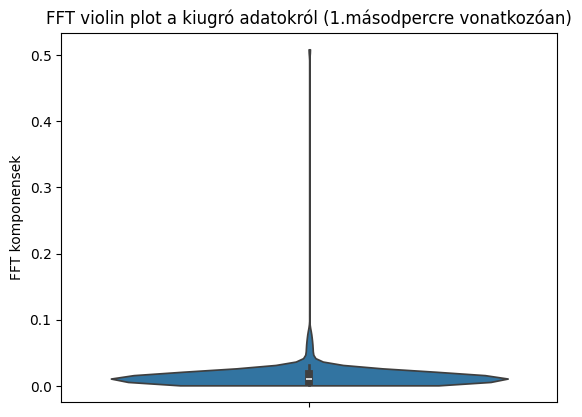

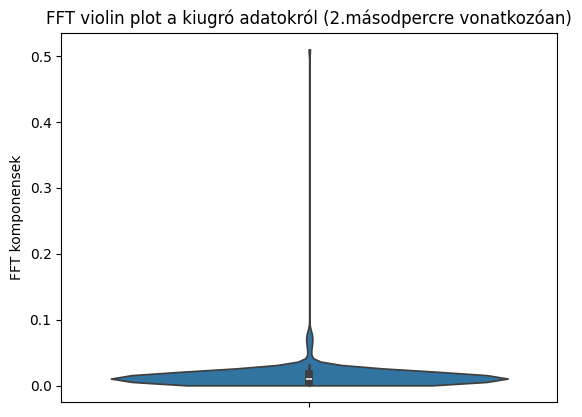

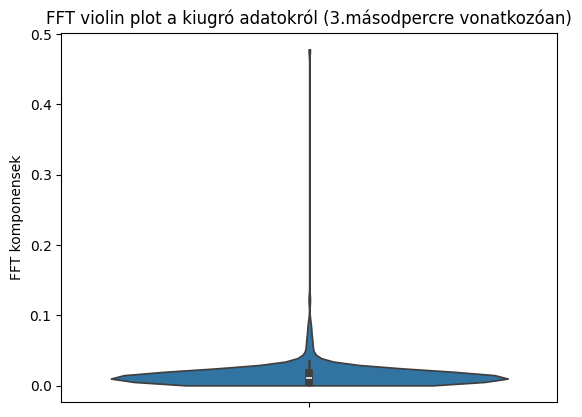

In [ ]:
# FFT

import seaborn as sns

for index, row in df_clean.iterrows():
    sns.violinplot(data=row, cut=0) # cut=0: a violin plot csak pontosan az adatok valós tartományáig terjed, és nem készül kiterjesztés a legkülső adatpontokon túlra
    plt.title(f'FFT violin plot a kiugró adatokról ({index+1}.másodpercre vonatkozóan)')
    plt.ylabel('FFT komponensek')
    plt.show()

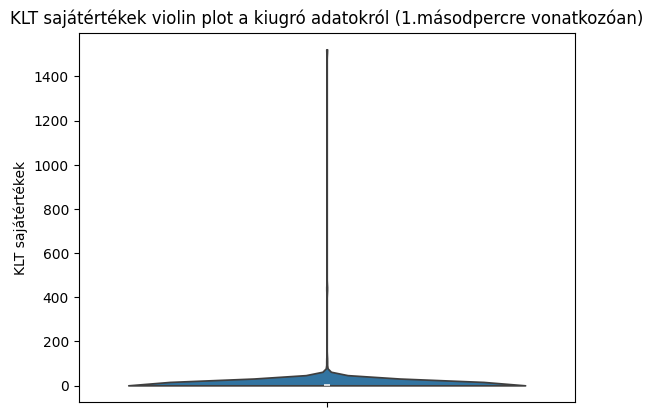

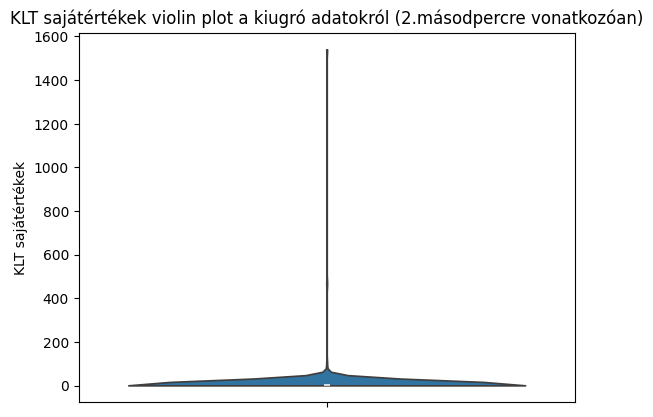

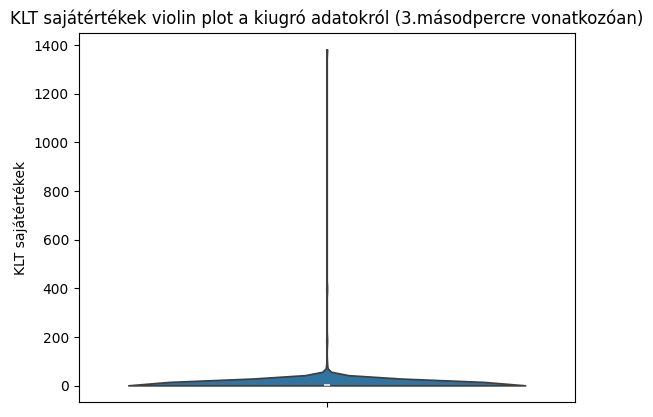

In [ ]:
# KLT sajátértékek

import seaborn as sns

for index, row in df_clean_values.iterrows():
    sns.violinplot(data=row, cut=0) # cut=0: a violin plot csak pontosan az adatok valós tartományáig terjed, és nem készül kiterjesztés a legkülső adatpontokon túlra
    plt.title(f'KLT sajátértékek violin plot a kiugró adatokról ({index+1}.másodpercre vonatkozóan)')
    plt.ylabel('KLT sajátértékek')
    plt.show()

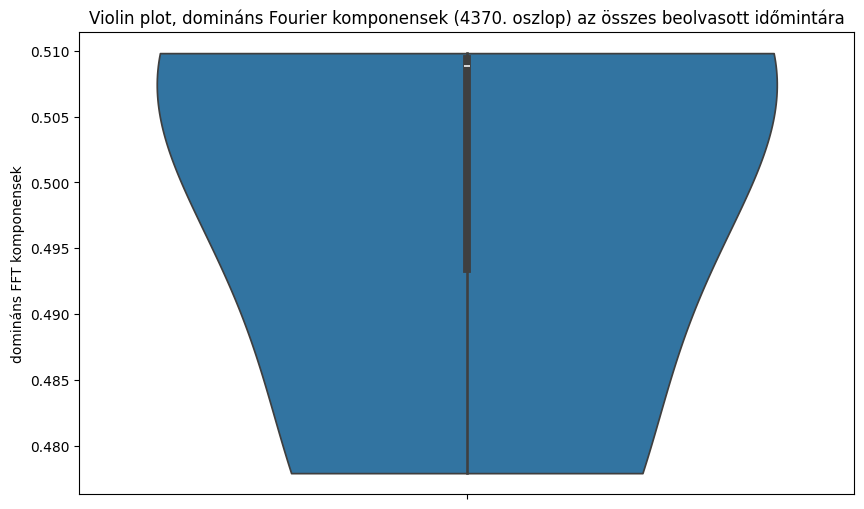

In [ ]:
# FFT

# Minden oszlop átlagának kiszámítása
column_means = df_clean.mean()
# A legnagyobb átlaggal rendelkező oszlop nevének meghatározása
max_mean_column = column_means.idxmax()

# A legnagyobb átlaggal rendelkező oszlop ábrázolása violin plot segítségével
plt.figure(figsize=(10, 6))  # Beállítjuk az ábra méretét
sns.violinplot(data=df_clean[max_mean_column], cut=0)  # A 'cut=0' itt is alkalmazható, ha szükséges
plt.title(f'Violin plot, domináns Fourier komponensek ({max_mean_column}. oszlop) az összes beolvasott időmintára')
plt.ylabel('domináns FFT komponensek')
plt.show()

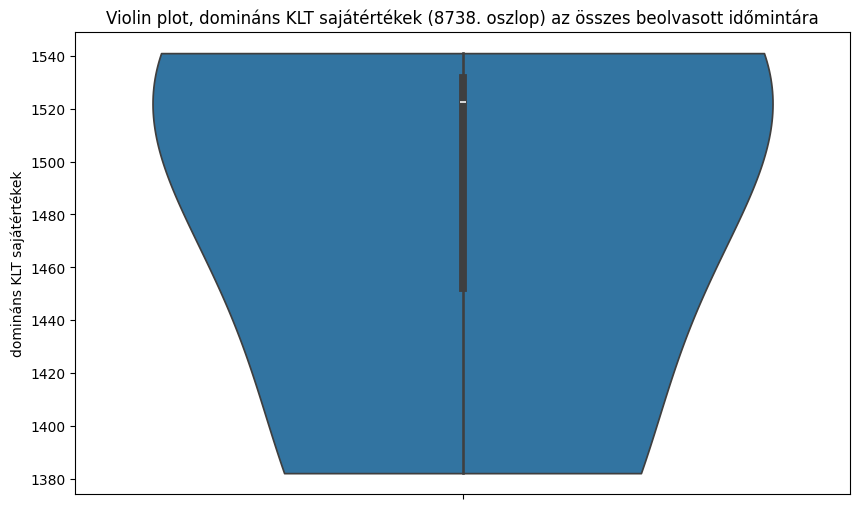

In [ ]:
# KLT sajátértékek

# Minden oszlop átlagának kiszámítása
column_means_values = df_clean_values.mean()
# A legnagyobb átlaggal rendelkező oszlop nevének meghatározása
max_mean_column_values = column_means_values.idxmax()

# A legnagyobb átlaggal rendelkező oszlop ábrázolása violin plot segítségével
plt.figure(figsize=(10, 6))  # Beállítjuk az ábra méretét
sns.violinplot(data=df_clean_values[max_mean_column_values], cut=0)  # A 'cut=0' itt is alkalmazható, ha szükséges
plt.title(f'Violin plot, domináns KLT sajátértékek ({max_mean_column_values}. oszlop) az összes beolvasott időmintára')
plt.ylabel('domináns KLT sajátértékek')
plt.show()

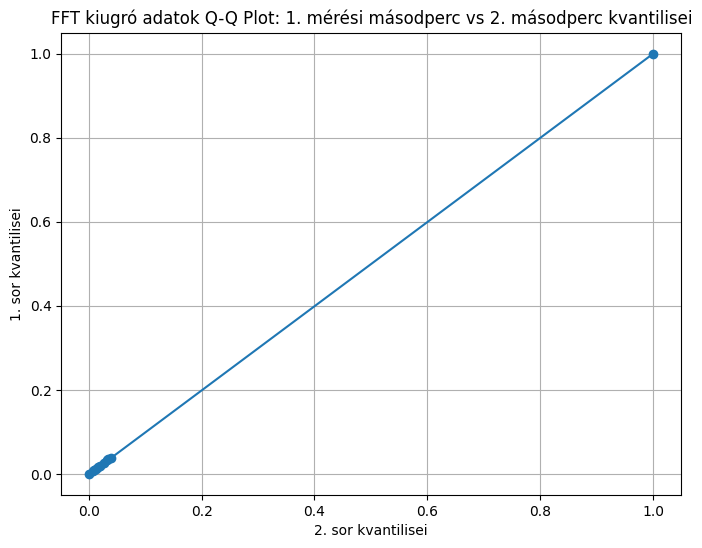

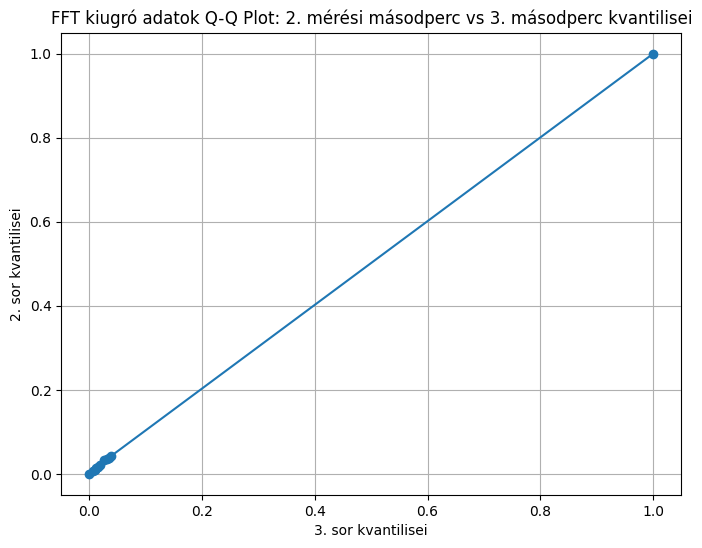

In [ ]:
# FFT

quantile_x = np.arange(0, 1.1, 0.1)

# Végigmegyünk az összes lehetséges sorpáron a DataFrame-ben
for i in range(len(df_clean) - 1):
    # A kvantilisek számítása az i. sorra és az i+1. sorra
    current_row_qs = [df_clean.iloc[i].quantile(q) / df_clean.iloc[i].max() for q in quantile_x]
    next_row_qs = [df_clean.iloc[i + 1].quantile(q) / df_clean.iloc[i + 1].max() for q in quantile_x]

    # Az aktuális és a következő sor kvantiliseinek ábrázolása
    plt.figure(figsize=(8, 6))
    plt.plot(current_row_qs, next_row_qs, marker='o')
    plt.xlabel(f'{i+2}. sor kvantilisei')
    plt.ylabel(f'{i+1}. sor kvantilisei')
    plt.title(f'FFT kiugró adatok Q-Q Plot: {i+1}. mérési másodperc vs {i+2}. másodperc kvantilisei')
    plt.grid(True)
    plt.show()

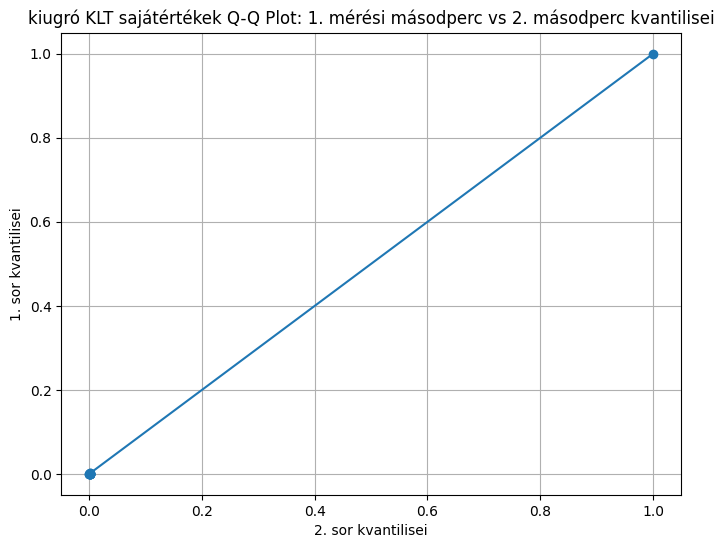

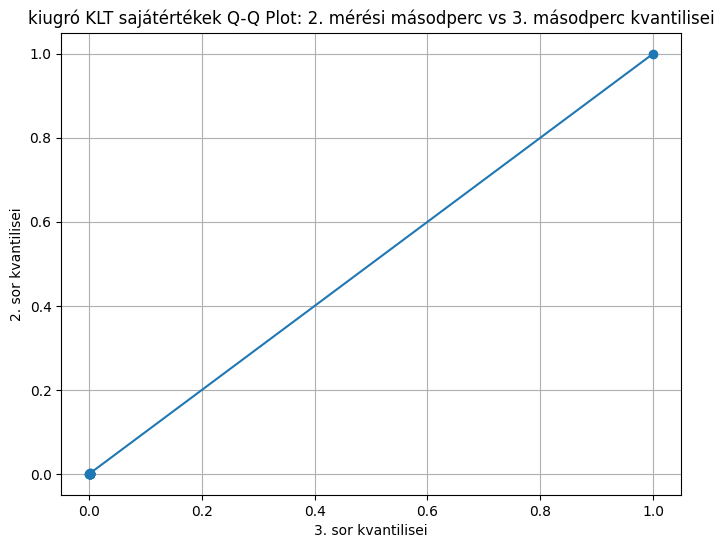

In [ ]:
# KLT sajátértékek

quantile_x = np.arange(0, 1.1, 0.1)

# Végigmegyünk az összes lehetséges sorpáron a DataFrame-ben
for i in range(len(df_clean_values) - 1):
    # A kvantilisek számítása az i. sorra és az i+1. sorra
    current_row_qs = [df_clean_values.iloc[i].quantile(q) / df_clean_values.iloc[i].max() for q in quantile_x]
    next_row_qs = [df_clean_values.iloc[i + 1].quantile(q) / df_clean_values.iloc[i + 1].max() for q in quantile_x]

    # Az aktuális és a következő sor kvantiliseinek ábrázolása
    plt.figure(figsize=(8, 6))
    plt.plot(current_row_qs, next_row_qs, marker='o')
    plt.xlabel(f'{i+2}. sor kvantilisei')
    plt.ylabel(f'{i+1}. sor kvantilisei')
    plt.title(f'kiugró KLT sajátértékek Q-Q Plot: {i+1}. mérési másodperc vs {i+2}. másodperc kvantilisei')
    plt.grid(True)
    plt.show()

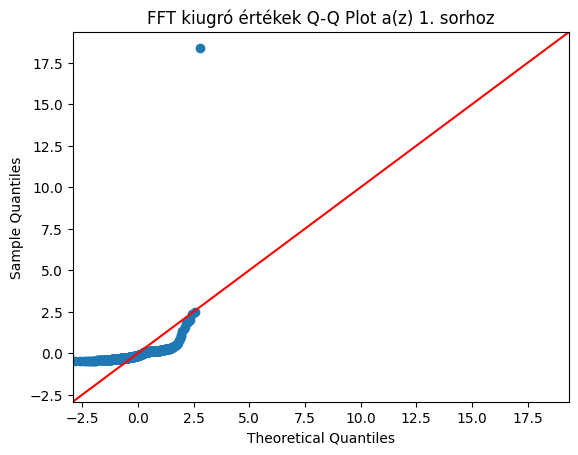

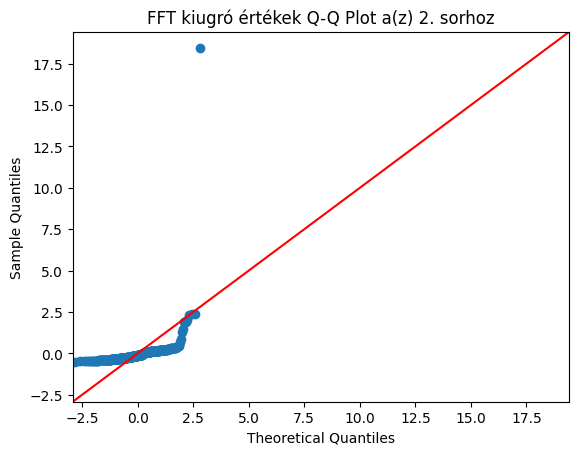

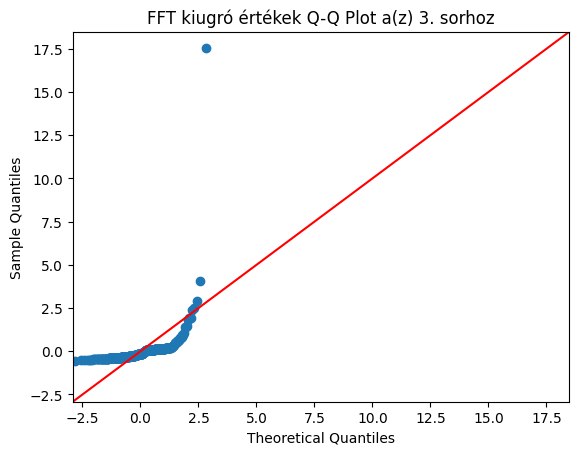

In [ ]:
# FFT

import statsmodels.api as sm

#AZ ADATOK IDŐVEL HOGYAN VISZONYULNAK A NORMÁLIS ELOSZLÁSHOZ:

# A df_clean DataFrame minden sorának iterálása és Q-Q plot készítése
for index, row in df_clean.iterrows():
    # A sor standardizálása: kivonjuk a sor átlagát és elosztjuk a sor szórásával
    row_std = (row - row.mean()) / row.std()

    # Q-Q plot készítése a standardizált sorra
    fig = sm.qqplot(row_std, line='45')
    plt.title(f'FFT kiugró értékek Q-Q Plot a(z) {index+1}. sorhoz')
    plt.show()

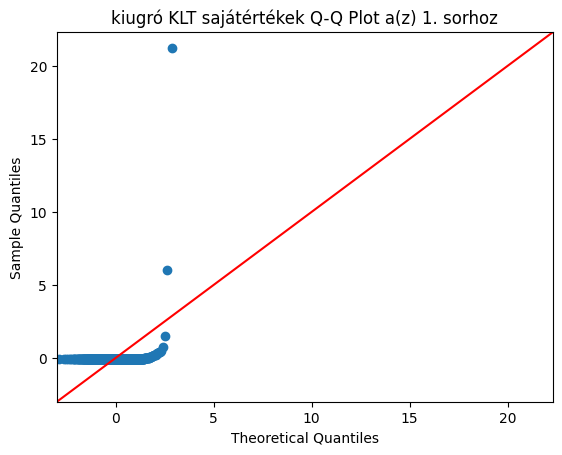

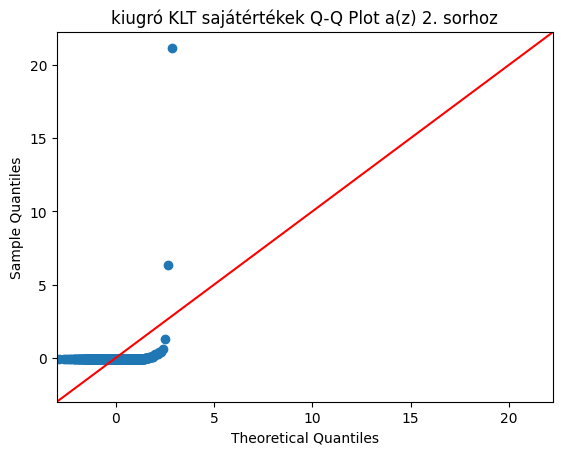

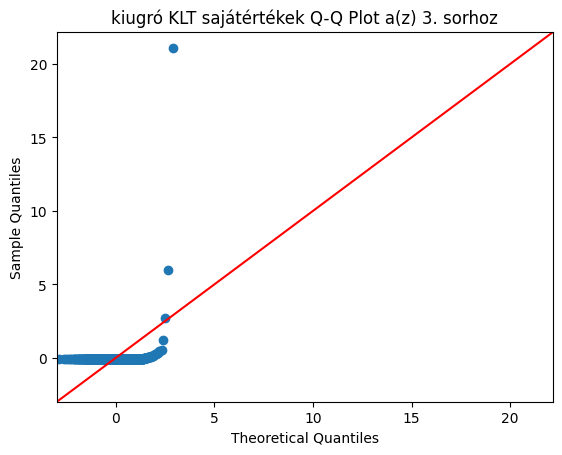

In [ ]:
# KLT sajátértékek

import statsmodels.api as sm

#AZ ADATOK IDŐVEL HOGYAN VISZONYULNAK A NORMÁLIS ELOSZLÁSHOZ:

# A df_clean DataFrame minden sorának iterálása és Q-Q plot készítése
for index, row in df_clean_values.iterrows():
    # A sor standardizálása: kivonjuk a sor átlagát és elosztjuk a sor szórásával
    row_std = (row - row.mean()) / row.std()

    # Q-Q plot készítése a standardizált sorra
    fig = sm.qqplot(row_std, line='45')
    plt.title(f'kiugró KLT sajátértékek Q-Q Plot a(z) {index+1}. sorhoz')
    plt.show()

In [ ]:
df_clean

,369,444,648,884,923,1019,1252,1367,1485,1508,...,7349,7374,7375,7415,7436,7454,7548,7733,7838,8388
0,0.016583,0.001229,0.016319,0.006363,0.002535,0.003462,0.016114,0.004775,0.005148,0.011634,...,0.018089,0.020154,0.012151,0.016499,0.003916,0.006544,0.016050,0.019800,0.005134,0.017520
1,0.008730,0.016378,0.006973,0.001584,0.016006,0.005519,0.000648,0.016287,0.017897,0.016584,...,0.002084,0.003981,0.017314,0.002774,0.005076,0.016155,0.006467,0.002866,0.001630,0.003204
2,0.005663,0.003537,0.003051,0.018963,0.007574,0.019677,0.003931,0.006362,0.008073,0.010601,...,0.010690,0.006031,0.011669,0.007678,0.016628,0.007376,0.007666,0.010894,0.016279,0.005509


In [ ]:
df_clean_values

,8244,8245,8246,8247,8248,8249,8250,8251,8252,8253,...,8729,8730,8731,8732,8733,8734,8735,8736,8737,8738
0,1.343411,1.344805,1.345861,1.346236,1.347429,1.348269,1.351509,1.352003,1.355399,1.356158,...,23.879835,29.627388,31.971331,35.084036,35.310277,39.763098,62.831815,114.538130,438.865562,1522.370623
1,1.319443,1.320752,1.320979,1.322158,1.323105,1.324126,1.324210,1.325598,1.325687,1.326067,...,25.092835,28.123282,28.174388,36.894062,38.088557,38.291855,49.653791,99.216758,468.661033,1541.049140
2,1.321730,1.321900,1.322065,1.322931,1.323657,1.324162,1.324805,1.325066,1.325848,1.326799,...,24.623415,26.612680,27.494534,37.035285,38.744267,39.579750,84.117558,185.056435,396.798361,1382.108291


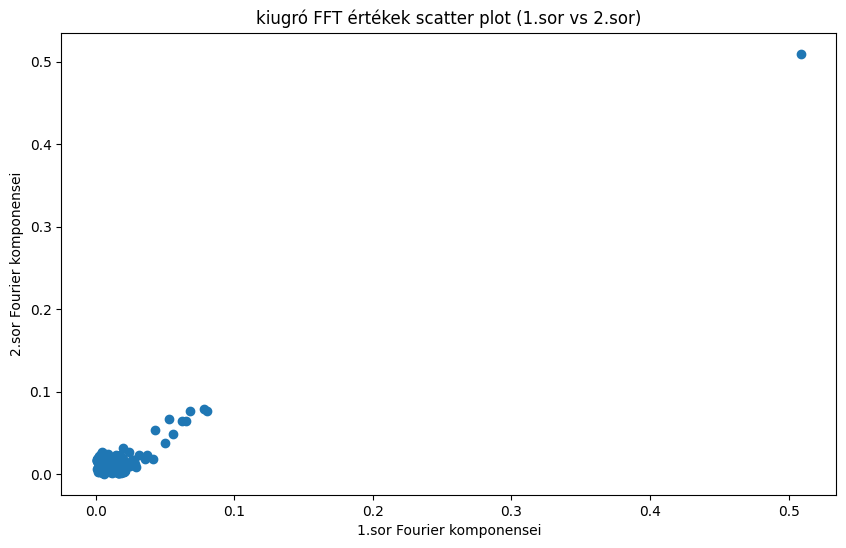

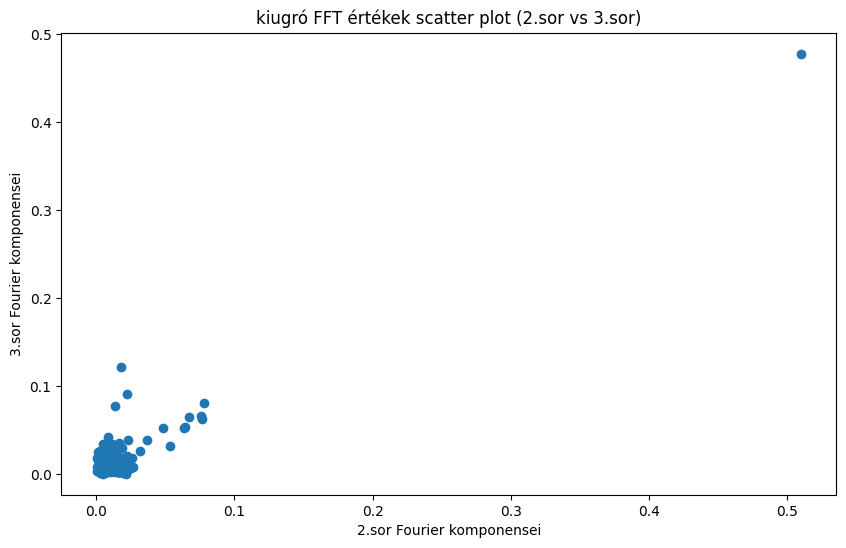

In [ ]:
# FFT

for i, (index, row) in enumerate(df_clean.iterrows()):
    # Az utolsó sor után ne próbáljuk meg rajzolni, mert nincs következő sor
    if i < len(df_clean) - 1:
        next_row = df_clean.iloc[i + 1]

        # Készítsünk egy scatter plotot az aktuális sor és a következő sor között
        plt.figure(figsize=(10, 6))
        plt.scatter(row, next_row)
        plt.title(f'kiugró FFT értékek scatter plot ({i+1}.sor vs {i + 2}.sor)')
        plt.xlabel(f'{i+1}.sor Fourier komponensei')
        plt.ylabel(f'{i + 2}.sor Fourier komponensei')
        plt.show()

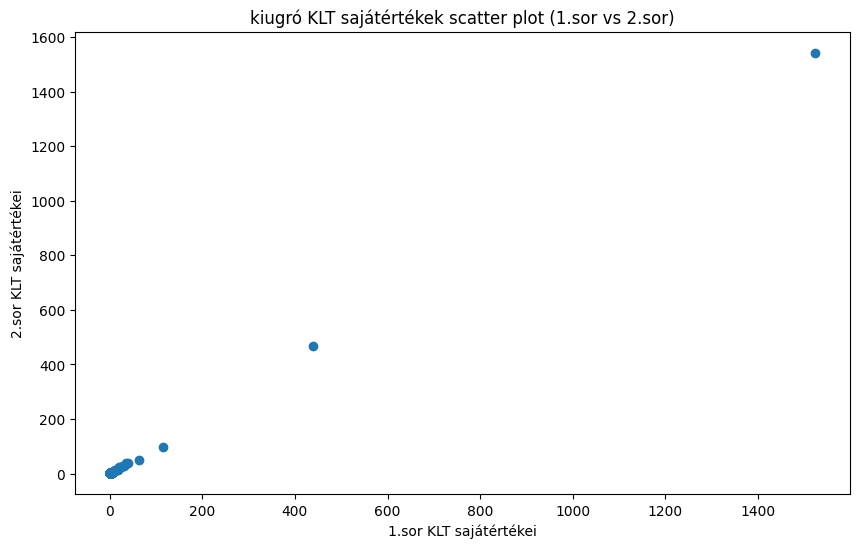

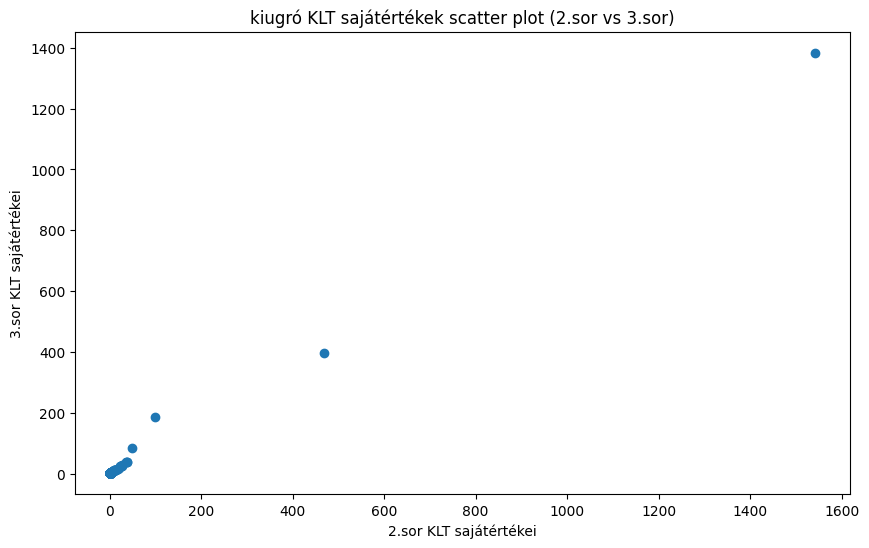

In [ ]:
# KLT sajátértékek

for i, (index, row) in enumerate(df_clean_values.iterrows()):
    # Az utolsó sor után ne próbáljuk meg rajzolni, mert nincs következő sor
    if i < len(df_clean_values) - 1:
        next_row = df_clean_values.iloc[i + 1]

        # Készítsünk egy scatter plotot az aktuális sor és a következő sor között
        plt.figure(figsize=(10, 6))
        plt.scatter(row, next_row)
        plt.title(f'kiugró KLT sajátértékek scatter plot ({i+1}.sor vs {i + 2}.sor)')
        plt.xlabel(f'{i+1}.sor KLT sajátértékei')
        plt.ylabel(f'{i + 2}.sor KLT sajátértékei')
        plt.show()

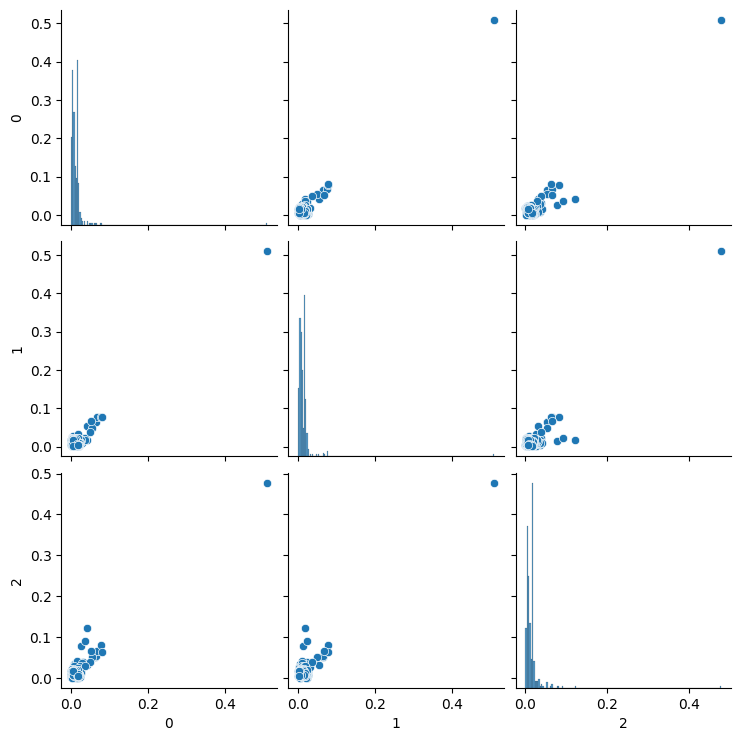

In [ ]:
# FFT

import seaborn as sns

# A DataFrame transzponálása, így a sorok változókká válnak
df_transposed = df_clean.T

# Pairplot készítése a transzponált DataFrame-re
sns.pairplot(df_transposed)

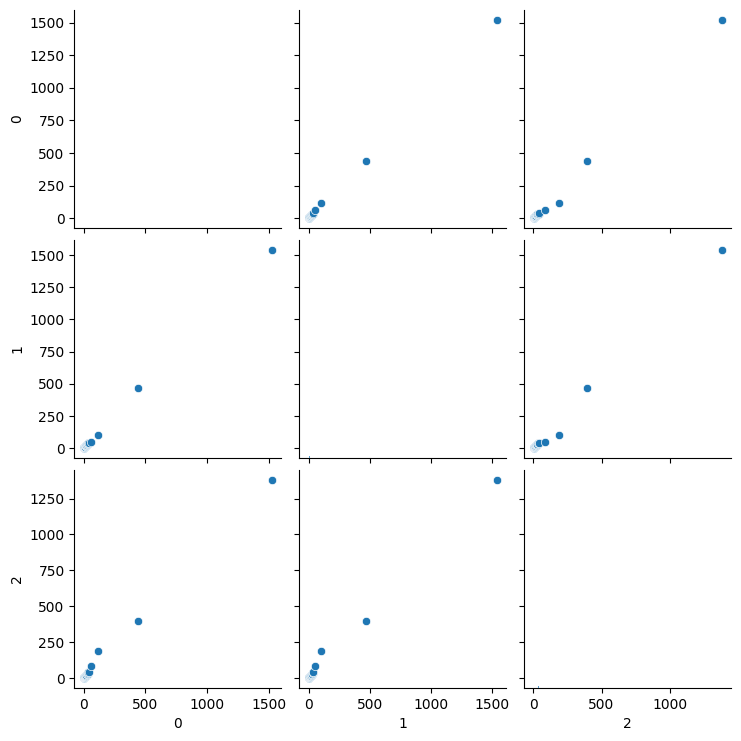

In [ ]:
# KLT sajátértékek

import seaborn as sns

# A DataFrame transzponálása, így a sorok változókká válnak
df_clean_values_transposed = df_clean_values.T

# Pairplot készítése a transzponált DataFrame-re
sns.pairplot(df_clean_values_transposed)

In [ ]:
df_clean

,369,444,648,884,923,1019,1252,1367,1485,1508,...,7349,7374,7375,7415,7436,7454,7548,7733,7838,8388
0,0.016583,0.001229,0.016319,0.006363,0.002535,0.003462,0.016114,0.004775,0.005148,0.011634,...,0.018089,0.020154,0.012151,0.016499,0.003916,0.006544,0.016050,0.019800,0.005134,0.017520
1,0.008730,0.016378,0.006973,0.001584,0.016006,0.005519,0.000648,0.016287,0.017897,0.016584,...,0.002084,0.003981,0.017314,0.002774,0.005076,0.016155,0.006467,0.002866,0.001630,0.003204
2,0.005663,0.003537,0.003051,0.018963,0.007574,0.019677,0.003931,0.006362,0.008073,0.010601,...,0.010690,0.006031,0.011669,0.007678,0.016628,0.007376,0.007666,0.010894,0.016279,0.005509


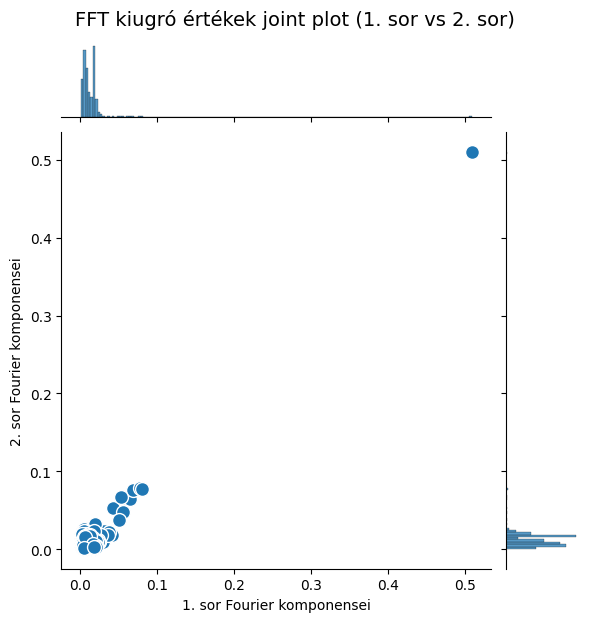

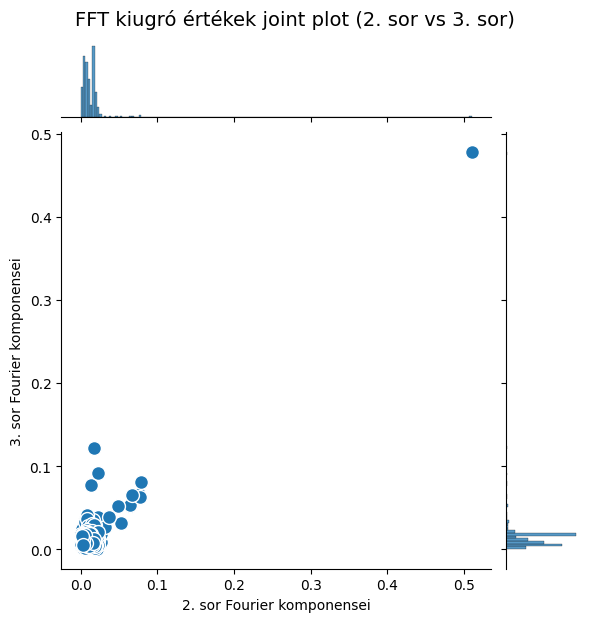

In [ ]:
# FFT

for i, (index, row) in enumerate(df_clean.iterrows()):
    if i < len(df_clean) - 1:  # Az utolsó sor után nem készítünk plotot
        next_row = df_clean.iloc[i + 1]

        # A jointplot készítése a két sor közötti scatter plot és hisztogramokkal
        g = sns.jointplot(x=row, y=next_row, kind="scatter", s=100, edgecolor="w", linewidth=1)

        # A tengelyfeliratok és a cím beállítása
        g.set_axis_labels(f'{i+1}. sor Fourier komponensei', f'{i + 2}. sor Fourier komponensei')
        g.fig.suptitle(f'FFT kiugró értékek joint plot ({i+1}. sor vs {i + 2}. sor)', fontsize=14, y=1.03)

        plt.show()

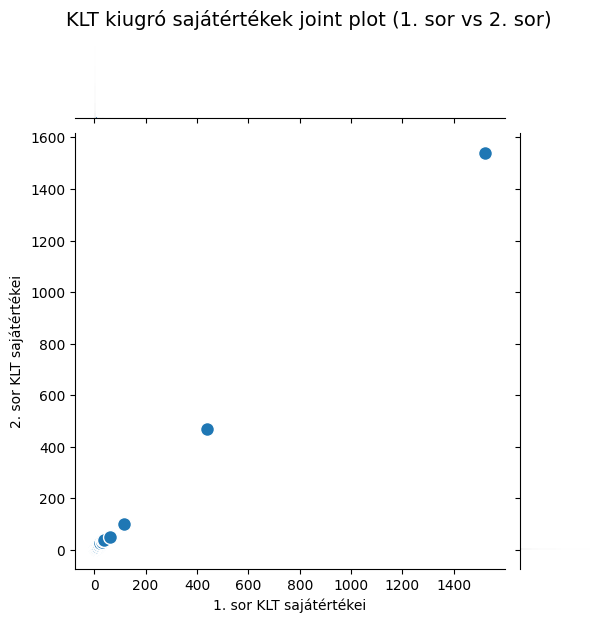

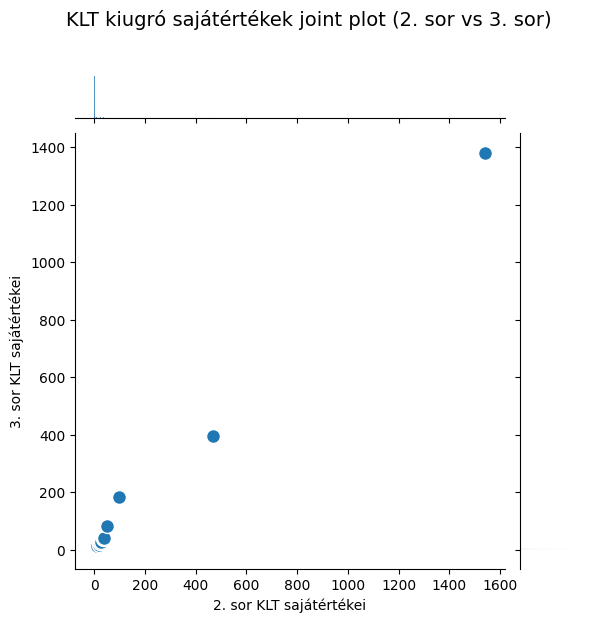

In [ ]:
# KLT sajátértékek

for i, (index, row) in enumerate(df_clean_values.iterrows()):
    if i < len(df_clean_values) - 1:  # Az utolsó sor után nem készítünk plotot
        next_row = df_clean_values.iloc[i + 1]

        # A jointplot készítése a két sor közötti scatter plot és hisztogramokkal
        g = sns.jointplot(x=row, y=next_row, kind="scatter", s=100, edgecolor="w", linewidth=1)

        # A tengelyfeliratok és a cím beállítása
        g.set_axis_labels(f'{i+1}. sor KLT sajátértékei', f'{i + 2}. sor KLT sajátértékei')
        g.fig.suptitle(f'KLT kiugró sajátértékek joint plot ({i+1}. sor vs {i + 2}. sor)', fontsize=14, y=1.03)

        plt.show()

# **Heat Maps**

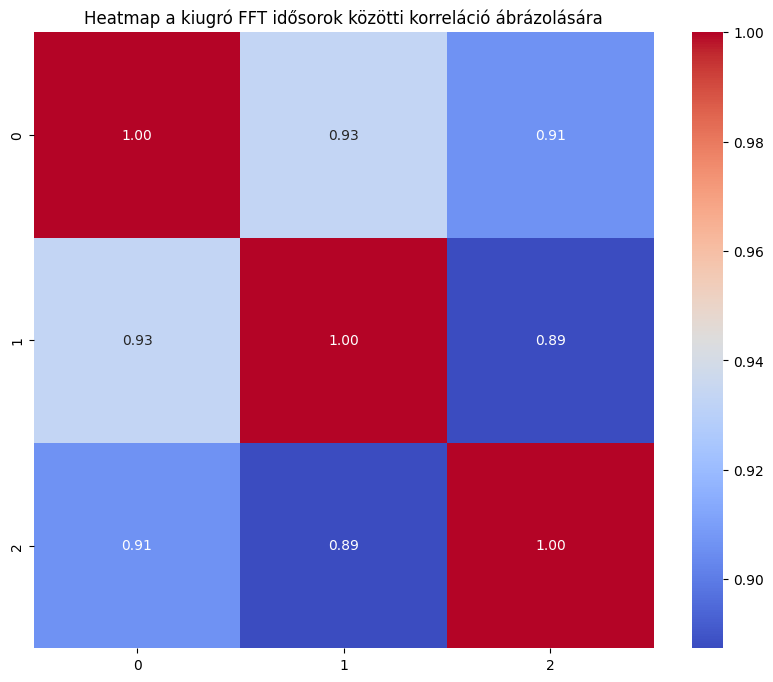

,0,1,2
0,1.000000,0.933537,0.905921
1,0.933537,1.000000,0.887384
2,0.905921,0.887384,1.000000


In [ ]:
# FFT
#ITT AZ VAN HOGY A JEL TELJES ENERGIÁJA (PONTOSABBAN A KIUGRÓ ÉRTÉKEK TELJES ENERGIÁJA) 1 MÁSODPERCNYI MÉRÉSBEN IDŐBEN HOGYAN KORRELÁL TOVÁBBI MÁSODPERCEKKEL, DE REGRESSZIÓNÁL NEM EZT FOGOM CSINÁLNI!!!

df_transposed = df_clean.T

# Korrelációs mátrix kiszámítása
corr_matrix = df_transposed.corr()

# Heatmap készítése a korrelációs mátrix alapján
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap a kiugró FFT idősorok közötti korreláció ábrázolására')
plt.show()

corr_matrix

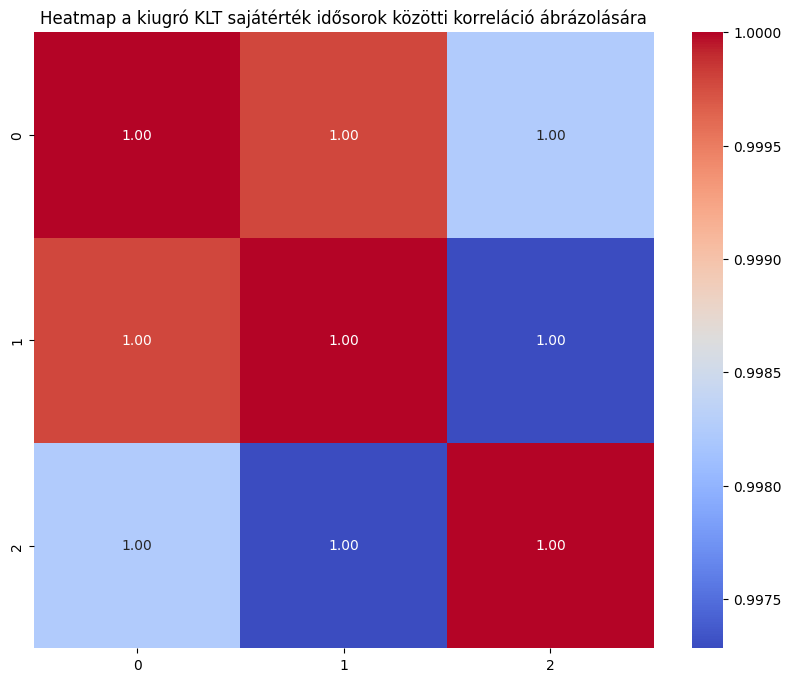

,0,1,2
0,1.000000,0.999784,0.998243
1,0.999784,1.000000,0.997283
2,0.998243,0.997283,1.000000


In [ ]:
# KLT sajátértékek
#ITT AZ VAN HOGY A JEL TELJES ENERGIÁJA (PONTOSABBAN A KIUGRÓ ÉRTÉKEK TELJES ENERGIÁJA) 1 MÁSODPERCNYI MÉRÉSBEN IDŐBEN HOGYAN KORRELÁL TOVÁBBI MÁSODPERCEKKEL, DE REGRESSZIÓNÁL NEM EZT FOGOM CSINÁLNI!!!

df_clean_values_transposed = df_clean_values.T

# Korrelációs mátrix kiszámítása
corr_matrix_values = df_clean_values_transposed.corr()

# Heatmap készítése a korrelációs mátrix alapján
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_values, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap a kiugró KLT sajátérték idősorok közötti korreláció ábrázolására')
plt.show()

corr_matrix_values